<a href="https://colab.research.google.com/github/lauraaconcari/ADM_HW2/blob/main/HW2_Finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 - The Best Books of All Time

## Reading the Data and Libraries

In [1]:
!wget -P "/content/drive/MyDrive/Colab Notebooks" https://sapienza2023adm.s3.eu-south-1.amazonaws.com/lighter_authors.json

--2023-11-05 14:09:39--  https://sapienza2023adm.s3.eu-south-1.amazonaws.com/lighter_authors.json
Resolving sapienza2023adm.s3.eu-south-1.amazonaws.com (sapienza2023adm.s3.eu-south-1.amazonaws.com)... 52.95.152.26, 52.95.151.12
Connecting to sapienza2023adm.s3.eu-south-1.amazonaws.com (sapienza2023adm.s3.eu-south-1.amazonaws.com)|52.95.152.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549013002 (524M) [application/json]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/lighter_authors.json’

lighter_authors.jso 100%[===================>] 523.58M  23.5MB/s    in 25s     

2023-11-05 14:10:04 (21.3 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/lighter_authors.json’ saved [549013002/549013002]



In [2]:
!wget -P "/content/drive/MyDrive/Colab Notebooks" https://sapienza2023adm.s3.eu-south-1.amazonaws.com/lighter_books.json

--2023-11-05 14:10:47--  https://sapienza2023adm.s3.eu-south-1.amazonaws.com/lighter_books.json
Resolving sapienza2023adm.s3.eu-south-1.amazonaws.com (sapienza2023adm.s3.eu-south-1.amazonaws.com)... 52.95.151.34, 52.95.153.46
Connecting to sapienza2023adm.s3.eu-south-1.amazonaws.com (sapienza2023adm.s3.eu-south-1.amazonaws.com)|52.95.151.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16123393395 (15G) [application/json]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/lighter_books.json’

lighter_books.json  100%[===================>]  15.02G  25.8MB/s    in 11m 34s 

2023-11-05 14:22:21 (22.2 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/lighter_books.json’ saved [16123393395/16123393395]



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import statsmodels.api as sm
import dask.dataframe as dd
import time
import io

from bs4 import BeautifulSoup
from datetime import datetime
from statistics import mode
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans


In [5]:
filename = "/content/drive/MyDrive/Colab Notebooks/lighter_authors.json"
filename1 = "/content/drive/MyDrive/Colab Notebooks/lighter_books.json"

In [6]:
# Set chunk size. By reading online it seems a good rule of thumb is to choose a chunksize around 100.000.
chunk_size = 100_000

In [7]:
#Define dtypes for dataframe
dtypes={'ratings_count': 'int32', 'text_reviews_count':'int32',
        'works_count':'int32', 'id':'string', 'fans_count':'int32',
        'name':'string', 'gender':'string', 'image_url':'string', 'average_rating':'float16',
        'about':'string'}

In [8]:
#DataFrame for authors dataset
df_chunks = pd.read_json(filename, lines=True, chunksize=chunk_size, dtype=dtypes)
# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Loop through each chunk and append it to the result DataFrame
for chunk in df_chunks:
  df = pd.concat([df, chunk], ignore_index=True)

In [9]:
# Set the dtypes for more efficient memory usage
dtype_mapping = {
    'id': 'int32',
    'author_id': 'int32',
    'work_id': 'int32',
    'ratings_count': 'int32',
    'text_reviews_count': 'int32',
    'average_rating': 'float16',
}

In [ ]:
#DataFrame for books dataset
df1_chunks = pd.read_json(filename1, lines=True, chunksize=chunk_size, dtype=dtype_mapping)
# Create an empty DataFrame to store the results
df1 = pd.DataFrame()

# Loop through each chunk and append it to the result DataFrame
for chunk in df1_chunks:
  chunk = chunk[['id', 'title', 'original_publication_date','publication_date', 'num_pages',
                 'series_name', 'author_name', 'author_id', 'average_rating', 'format',
                 'rating_dist', 'ratings_count', 'text_reviews_count', 'language']]
    #only some columns are needed for the tasks, so the file will be read more than once, but with different columns, throughout the notebook
    #reading the entire file without restraints can result in System Crashes because of the RAM
  df1 = pd.concat([df1, chunk], ignore_index=True)

In [ ]:
#DataFrame for RQ7.3, the file was downloaded since it was really small
df3=pd.read_json('list.json', nrows=5, lines=True) #we actually only need the first row



---





# [RQ1] Exploratory Data Analysis (EDA)





### Examine the lighter authors dataset

In [ ]:
# Print info about the dtypes
print(df.info())
# Print summaries of quanitative variables in the df
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int32  
 1   average_rating      351767 non-null  float16
 2   text_reviews_count  351767 non-null  int32  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int32  
 6   id                  351767 non-null  string 
 7   name                351767 non-null  string 
 8   gender              351767 non-null  string 
 9   image_url           351767 non-null  string 
 10  about               351767 non-null  string 
 11  fans_count          351767 non-null  int32  
dtypes: float16(1), int32(4), object(2), string(5)
memory usage: 24.8+ MB
None
       ratings_count  average_rating  text_reviews_count   works_count  \
count   3.517670e+05   351767.000000

In [ ]:
# Visualize the first 5 rows of the df
df.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.191406,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.019531,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.531250,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.789062,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.599609,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [ ]:
# Check unique values
genders = df['gender'].unique()
names = df['name'].unique()
ids = df['id'].unique()

In [ ]:
print('All unique gender values in the data set: ', genders)
print('Total number of unique gender values: ', len(genders))

All unique gender values in the data set:  <StringArray>
[              'male',             'female',                   '',
        'genderfluid',        'genderqueer', 'transgender female',
 'apache  Helicopter',            'Fiction',               'none',
            'Unknown',
 ...
     'I have no idea',             'Muppet',          'abbudabbi',
  'Genderqueer Femme',         'trans male',  'transgender woman',
            'Genderq',         'Non Binary',        'Genderqueen',
             'Tomboy']
Length: 150, dtype: string
Total number of unique gender values:  150


In [ ]:
# Print number of unique ids and names to check if there are duplicates
print('Number of unique author ids: ', len(ids))
print('Number of unique author names: ',len(names))

Number of unique author ids:  351767
Number of unique author names:  351730


It's best to use author ids since there seems to be some cases of eponymouses

In [ ]:
# Verify if there are any missing data
missing = df.isna().sum()
# Check for empty values
empty = df[df == ''].count()

print('Missing data:\n', missing)
print('\nEmpty data:\n', empty)

Missing data:
 ratings_count         0
average_rating        0
text_reviews_count    0
work_ids              0
book_ids              0
works_count           0
id                    0
name                  0
gender                0
image_url             0
about                 0
fans_count            0
dtype: int64

Empty data:
 ratings_count              0
average_rating             0
text_reviews_count         0
work_ids                   0
book_ids                   0
works_count                0
id                         0
name                       0
gender                103377
image_url                  0
about                      0
fans_count                 0
dtype: int64


Handle genders by creating a mapping to 4 categories

In [ ]:
print(len(df[df.gender == 'female'] == True))
print(len(df[df.gender == 'male'] == True))

109878
138179


In [26]:
# Define category mappings
category_mapping = {
    # Male Genders
    'Male': {
        'Male', 'male', 'man', 'Man'
    },

    # Female Genders
    'Female': {
        'Female', 'Woman', 'Femme', 'She/Her/Hers', 'female'
    },

    # Non-binary Genders
    'Queer': {
        'Non-binary', 'Non-binary (multiple instances)', 'Non binary', 'Non-Binary', 'Non-binary Woman',
        'Nonbinary', 'Nonbinary Woman', 'Nonbinary genderfluid', 'Non-binary genderqueer', 'Non-binary trans guy',
        'Non-binary/transmasculine', 'Non-binary Transgender', 'Non-Binary Transgender', 'Non binary trans person', 'Non binary trans woman',
        'Non-binary Transmasculine', 'Non-Binary Woman', 'Bigender', 'Bigender (female and agender)', 'Two-spirit', 'Agender',
        'Genderqueer', 'Genderqueer transfemme', 'Genderqueer Femme', 'Genderqueer genderfluid', 'Genderqueer non-binary',
        'Genderqueer transfeminine', 'Gender Non-Conforming', 'Genderless', 'Androgynous', 'Transmasculine non-binary', 'Transfemale', 'Transgender female',
        'Transfeminine', 'Trans-female', 'Transwoman', 'Trans woman', 'Trans man', 'Male (FtM)', 'Trans-Male', 'Transman',
        'Transmasculine', 'Trans male', 'Transgender male', 'FtM',
    },
}

In [27]:
def update_gender(gender):
    for new_gender, mappings in category_mapping.items():
        if gender in mappings:
            return new_gender
    return 'Other'  # Assign to 'Other' if not found in any category

# Apply the custom function to update the genders
df['gender'] = df['gender'].apply(update_gender)

In [ ]:
print(len(df[df.gender == 'Female'] == True))
print(len(df[df.gender == 'Male'] == True))

109882
138180


 The number of male and females increased since before there were
different ways in which the same gender was defined

### Examine the lighter Books dataset

In [ ]:
# Peek into the dataset by looking at the first rows
df1.head()

,id,title,original_publication_date,publication_date,num_pages,series_name,author_name,author_id,average_rating,format,rating_dist,ratings_count,text_reviews_count,language
0,2,Harry Potter and the Order of the Phoenix (Har...,2003-06-21,2004-09,870,Harry Potter,J.K. Rowling,1077326,4.50,Paperback,5:1674064|4:664833|3:231195|2:41699|1:16215|to...,2628006,44716,eng
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,1997-06-26,2003-11-01,309,Harry Potter,J.K. Rowling,1077326,4.48,Hardcover,5:4801606|4:1681521|3:623286|2:145898|1:125040...,7377351,116930,eng
2,4,Harry Potter and the Chamber of Secrets (Harry...,1998-07-02,2003-11-01,352,Harry Potter,J.K. Rowling,1077326,4.43,Hardcover,5:1690166|4:781011|3:313727|2:54687|1:15453|to...,2855044,55286,eng
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,1999-07-08,2004-05-01,435,Harry Potter,J.K. Rowling,1077326,4.57,Mass Market Paperback,5:1994597|4:696545|3:212678|2:28915|1:13959|to...,2946694,58023,eng
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,2000-07-08,2002-09-28,734,Harry Potter,J.K. Rowling,1077326,4.56,Paperback,5:1808039|4:663849|3:193604|2:27759|1:12425|to...,2705676,48637,eng


In [ ]:
#Initialize variables to store info
info = {}
# Compute memory usage
total_memory_usage = df1.memory_usage(deep=True).sum()

# Gather data types and non-null counts
for column in df1.columns:
    column_dtype = df1[column].dtype

    # Aggregate the information
    if column in info:
        info[column]['Data Types'].add(column_dtype)
        info[column]['Non-Null Count'] += df1[column].count()
    else:
        info[column] = {'Data Types': {column_dtype}, 'Non-Null Count': df1[column].count()}

# Create a DataFrame from the gathered information
info_df = pd.DataFrame(info).T.reset_index()
info_df.rename(columns={'index': 'Column Name'}, inplace=True)

# Print the aggregated info
print("Info for the Whole Data Frame:")
print(info_df)

Info for the Whole Data Frame:
                  Column Name Data Types Non-Null Count
0                          id    {int64}        7027431
1                       title   {object}        7027431
2   original_publication_date   {object}        7027431
3            publication_date   {object}        7027431
4                   num_pages   {object}        7027431
5                 series_name   {object}        7027431
6                 author_name   {object}        7027431
7                   author_id    {int64}        7027431
8              average_rating  {float64}        7027431
9                      format   {object}        7027431
10                rating_dist   {object}        7027431
11              ratings_count    {int64}        7027431
12         text_reviews_count    {int64}        7027431
13                   language   {object}        7027431


In [ ]:
# Initialize variables to store statistics
missing = df1.isna().sum()
empty = df1[df1 == ''].count()
blocks= df1[['average_rating', 'ratings_count', 'text_reviews_count']]

# Print the missing and empty data
print('Missing Data\n', missing)
print('\nEmpty Data\n', empty)

# Print the aggregated statistics
print("\nAggregated Statistics for Specific Columns")
print("\nMean:")
print(blocks.mean())
print("\nStandard Deviation:")
print(blocks.std())
print("\nQuantiles:")
print(blocks.quantile([0.25, 0.5, 0.75]))
print("\nMinimum")
print(blocks.min())
print("\nMaximum")
print(blocks.max())

Missing Data
 id                           0
title                        0
original_publication_date    0
publication_date             0
num_pages                    0
series_name                  0
author_name                  0
author_id                    0
average_rating               0
format                       0
rating_dist                  0
ratings_count                0
text_reviews_count           0
language                     0
dtype: int64

Empty Data
 id                                 0
title                             33
original_publication_date     415746
publication_date             2138139
num_pages                    3071835
series_name                  5162328
author_name                        0
author_id                          0
average_rating                     0
format                       2240100
rating_dist                        0
ratings_count                      0
text_reviews_count                 0
language                     4340264
dtype: i



---




# [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

In [25]:
#DataFrame for books dataset
df1_chunks = pd.read_json(filename1, lines=True, chunksize=chunk_size, dtype=dtype_mapping)
# Create an empty DataFrame to store the results
df1 = pd.DataFrame()

# Loop through each chunk and append it to the result DataFrame
for chunk in df1_chunks:
  chunk = chunk[['title', 'num_pages', 'average_rating', 'ratings_count', 'text_reviews_count', 'language']]
    #only some columns are needed for the tasks
  df1 = pd.concat([df1, chunk], ignore_index=True)

### Plot the number of books for each author in descending order.

<ipython-input-28-f9b5ff690b83>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genders['book_count'] = df_genders['book_ids'].apply(count_unique_books)


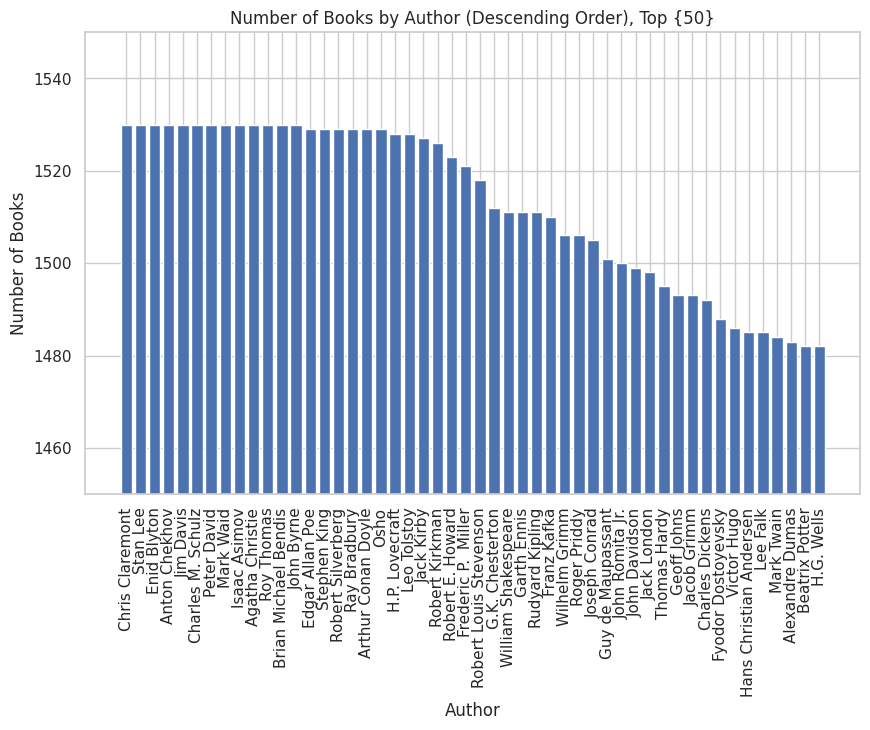

In [28]:
# Since in the authors there are also publishers and companies, filter the authors using gender
# Companies and publishers will have a gender that is not female, male or queer

df_genders = df[df['gender'] != 'Other']

def count_unique_books(book_list):
    return len(set(book_list))

# Count the number of books for each author
df_genders['book_count'] = df_genders['book_ids'].apply(count_unique_books)

# Sort the DataFrame in descending order by book count
df_genders = df_genders.sort_values(by='book_count', ascending=False)

# Choose the top N authors since plotting all of them would result in a plot not very messy and not meaningful
N = 50
df_plot = df_genders.head(N)

# Plot the number of books for each author
plt.figure(figsize=(10, 6))
plt.bar(df_plot['name'], df_plot['book_count'])
plt.xticks(rotation=90)
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.title('Number of Books by Author (Descending Order), Top {%s}' % N)
plt.ylim([1450, 1550])

plt.show();

### Which book has the highest number of reviews?

In [ ]:
# Create a dictionary to store review counts for each book
review_counts = {}

# Iterate through each chunk and update the review counts
chunk = df1[['title', 'text_reviews_count']]
# Since there are more editions for every book, but we are interested in the book with the most reviews, not the edition,
# we group the books by title
chunk = chunk.groupby('title')['text_reviews_count'].sum().reset_index()


# Update the review counts in the dictionary
for _, row in chunk.iterrows():
    book_title = row['title']
    review_count = row['text_reviews_count']
    review_counts[book_title] = review_counts.get(book_title, 0) + review_count

# Find the book with the highest number of reviews
max_reviews_book = max(review_counts, key=review_counts.get)
max_reviews_count = review_counts[max_reviews_book]

print(max_reviews_book, max_reviews_count)

Pride and Prejudice 85759005


In [ ]:
# If instead we are interested in the edition of the book with most reviews
chunk = df1[['title', 'text_reviews_count']]

print('Title', chunk.sort_values(by='text_reviews_count').iloc[-1][0])
print('reviews', chunk.sort_values(by='text_reviews_count').iloc[-1][1])

Title The Hunger Games (Hunger Games, #1)
reviews 174524


### Which are the top ten and ten worst books concerning the average score?

In [ ]:
# Create a dictionary to store average rating for each book
ratings = {}
chunk = df1[['title', 'average_rating', 'ratings_count']]
chunk.average_rating.apply(lambda x: x if x >= 0 else None)
chunk.title.apply(lambda x: x if x != '' else None).dropna()
chunk = chunk[chunk['ratings_count'] > 1]

# Update the review counts in the dictionary
for _, row in chunk.iterrows():
    if row['title'] in ratings:
      ratings[row['title']].append(row['average_rating'])
    else:
      ratings[row['title']] = [row['average_rating']]

for title, average_rating in ratings.items():
  ratings[title] = sum(average_rating)/len(average_rating)

sorted_d = sorted(ratings.items(), key=lambda x: x[1])

worst_ten = sorted_d[:10]
top_ten = sorted_d[-10:]

print('Top ten books concerning average rating', top_ten)
print('\nWorst ten books concerning average rating: ', worst_ten)

Top ten books concerning average rating [('Deranged Loverz 2', 5.0), ("Finding Christmas Love and Other Stories (Juliette Hill's Christmas Romances Book 1)", 5.0), ('Ethos Equinox #2', 5.0), ('Incoming: Collected Stories', 5.0), ('The Adventures of Amy', 5.0), ('Bentley The Bunny - Bentley learns to like Veggies', 5.0), ('Freie Stunden am Fenster', 5.0), ('Die Bücher und die Leserwelt', 5.0), ('Karya Pena Dik A 2014', 5.0), ('Seeking Paradise / Swinging in Paradise', 5.0)]

Worst ten books concerning average rating:  [('The Hero Rises Up (Modern Plays)', 1.0), ('Constructing Animerica: History, Style and Spectatorship of Anime in the United States', 1.0), ('Sacred Interconnections: Postmodern Spirituality, Political Economy & Art (Constructive Postmodern Thought)', 1.0), ('The Mathematical Palette (with BCA/iLrn(TM) Tutorial and InfoTrac) (Advantage Series)', 1.0), ('The Infidelity Report: An Investigation Of Extramarital Affairs', 1.0), ("Medicine Dharma Reiki: An Introduction to the 

### Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [ ]:
# Create a Series to store the language's count
languages = pd.Series([], dtype='object')
#Select langauge column
df1.dropna(subset=['language'], inplace=True)
# Count the values for the languages
languages = df1.language.value_counts()

languages1 = languages.to_frame().reset_index()
result = languages1.groupby('index').sum()
result = result.reset_index()
result = result.rename(columns={'index':'lang', 'language':'count'})

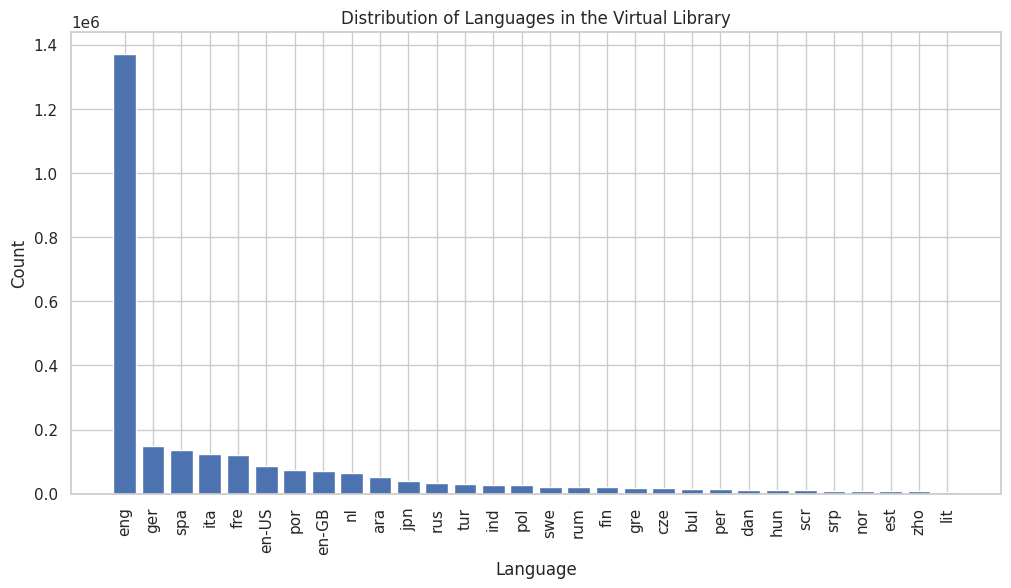

In [ ]:
res2 = result.sort_values(by='count', ascending=False)
res2 = res2.drop(0)

plt.figure(figsize=(12, 6))
plt.bar(res2['lang'][:30], res2['count'][:30])
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Languages in the Virtual Library')
plt.xticks(rotation=90)
plt.show()

### How many books have more than 250 pages?

In [ ]:
# subselect only the column that contains the number of pages
chunk = df1[['num_pages']]
# clean the data and convert the datatype
chunk = chunk[chunk['num_pages'] != '']
chunk = chunk.dropna(subset=['num_pages'])
chunk['num_pages'] = chunk['num_pages'].astype('uint32')
# Update the count
b_250_count = chunk[chunk['num_pages'] > 250]['num_pages'].count()

print('The books with more than 250 pages are:', b_250_count)


The books with more than 250 pages are: 1810335


### Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

In [ ]:
# FIlter by gender to remove publishers and companies
df_filtered = df[df['gender'] != 'Other']
# Ensure fans count is > 0 and not Null
df_filtered['fans_count'] = df_filtered.fans_count.apply(lambda x: x if x > 0 else None)
df_filtered.dropna(subset=['fans_count'], inplace=True)

# Count the number of books for each author
df_filtered['book_count'] = df_filtered['book_ids'].apply(count_unique_books)

# Sort the DataFrame in descending order by book count
df_filtered = df_filtered.sort_values(by='book_count', ascending=False)

# Create a dataframe with only the top 50 authors
top_50_authors = df_filtered['id'][:50]
df_top_50_authors = df_filtered[df_filtered['id'].isin(top_50_authors)]

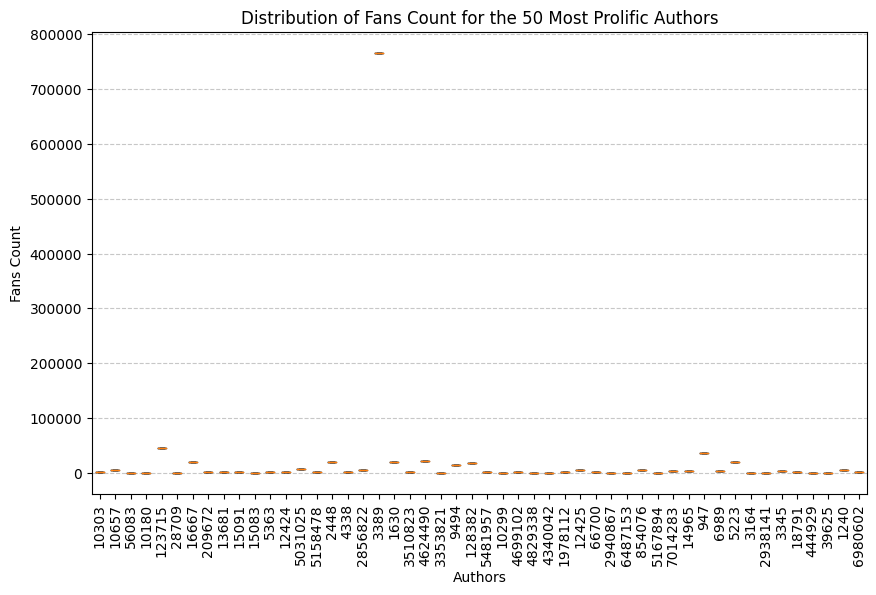

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([df_top_50_authors[df_top_50_authors['id'] == author]['fans_count'] for author in top_50_authors], labels=top_50_authors)
plt.xlabel('Authors')
plt.ylabel('Fans Count')
plt.title('Distribution of Fans Count for the 50 Most Prolific Authors')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print('There is an outlier that we excluded from the representation (not from the distribution)', df_top_50_authors.loc[df_top_50_authors.fans_count.idxmax(), 'name'], 'that has # of fans', df_top_50_authors.loc[df_top_50_authors.fans_count.idxmax(), 'fans_count'])

There is an outlier that we excluded from the representation (not from the distribution) Stephen King that has # of fans 766035.0


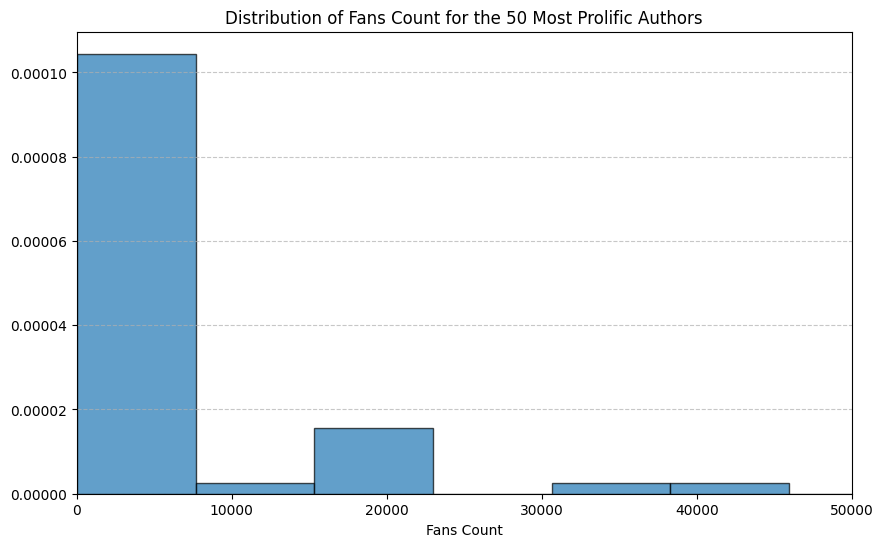

In [ ]:
# Create a histogram to plot the distribution of fans count
plt.figure(figsize=(10, 6))
plt.hist(df_top_50_authors['fans_count'], bins=100, edgecolor='k', alpha=0.7, density=True)
plt.xlabel('Fans Count')
plt.title('Distribution of Fans Count for the 50 Most Prolific Authors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim([0, 50_000])

plt.show()



---


# [RQ3] Let’s have a historical look at the dataset!

In [ ]:
#DataFrame for books dataset
df1_chunks = pd.read_json(filename1, lines=True, chunksize=chunk_size, dtype=dtype_mapping)
# Create an empty DataFrame to store the results
df1 = pd.DataFrame()

# Loop through each chunk and append it to the result DataFrame
for chunk in df1_chunks:
  chunk = chunk[['id', 'title', 'original_publication_date','num_pages', 'author_name', 'format','series_name']]
    #only some columns are needed for the tasks
  df1 = pd.concat([df1, chunk], ignore_index=True)

### Write a function that takes as input a year and returns as output the following information:


*   The number of books published that year.
*   The total number of pages written that year.

*   The most prolific month of that year.
*   The longest book written that year.

In [ ]:
#We create two different lists, date with the entire original publication date in tuples, and date_y with just the year.
#The problem is that for some books the month is missing.
date_y=[]
date_m=[]
for i in df1.original_publication_date:
    date_y.append(i.split('-')[0])
    #Some books don't have the specified month of publication date, but just the year.
    #So we create a list for the months and when it is not specified we insert 0.
    if len(i.split('-')) > 1:
        date_m.append(i.split('-')[1])
    else:
        date_m.append(0)

date_y = ['0' if i == '' else i for i in date_y]
date_y = [int(i) for i in date_y]
date_m = [int(i) for i in date_m]
#We add the column with the years and the months
df1['publication_year'] = date_y
df1['publication_month'] = date_m
df1['num_pages'] = df1['num_pages'].replace('', '0')
df1['num_pages'] = df1['num_pages'].astype(int)
# We filter the books based on the publication year
# We remove books published after 2024 and before 31 since this year may come from an
# incorrect format of the date %d-%m
filter = (df1['publication_year'] > 99) & (df1['publication_year'] < 2024)
df_books_filtered_y = df1[filter]

In [ ]:
print(len(df1))
print(len(df_books_filtered_y))

7027431
6583754


In [ ]:
def info_year(year):
    books = df1[df1['publication_year'] == year]

    #The number of books published that year:
    published_b = len(books.index)

    #The total number of pages written that year:
    num_pages = books['num_pages'].sum()

    #The most prolific month of that year:
    months = books['publication_month']
    months_small = []
    for i in months: #Eliminating the 0 that are the unspecified months
        if i != 0 and i < 13:
            months_small.append(i)
    if months_small:
        frequent_month = mode(months_small)
    else: #In the case this list is empty, it means that the months were all 0 (not specified)
        frequent_month = "There isn't enough information to find the most prolific month of this year"

    #The longest book written that year:
    index_max = books['num_pages'].idxmax() #Estracting the index of the maximum
    longest_b = books.loc[index_max, 'title']


    return(published_b, num_pages, frequent_month, longest_b)

### Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.



In [ ]:
years = df_books_filtered_y['publication_year'].unique() #years is the primary key
list_years = [[i] + list(info_year(i)) for i in years]

df_years = pd.DataFrame(list_years, columns = ['years', 'published_books', 'tot_num_pages', 'most_frequent_month', 'longest_book'])
df_years.sort_values(by='years', inplace=True)
print('First ten years registered:')
print(df_years.head(10))
print('\nLast ten years registered:')
print(df_years.tail(10))

First ten years registered:
      years  published_books  tot_num_pages  \
363     100              563         123985   
972     101                3            192   
661     102               24           2605   
442     103               35           5114   
832     104                9           2628   
775     105                2            698   
1097    106                2            106   
982     107                2            107   
287     108               46           8075   
569     109               57           8190   

                                    most_frequent_month  \
363                                                   1   
972   There isn't enough information to find the mos...   
661   There isn't enough information to find the mos...   
442                                                   1   
832                                                   1   
775                                                   3   
1097                                     

We see that, despite the filtering that we did, there are still some obvious mistakes in the dataset. Ex dreams and echoes

### Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

In [ ]:
# Assuming you have two DataFrames 'df' and 'df1' as you described
# Extract the year from the 'original_publication_date' column in df1
df1['publication_year'] = pd.to_datetime(df1['original_publication_date'], errors='coerce').dt.year

# Define a function to get information for a specific year
def get_yearly_info(year):
    select_books = df1[df1['publication_year'] == year]

    # The number of books published that year
    published_books = len(select_books)

    # The total number of pages written that year
    select_books['num_pages'] = pd.to_numeric(select_books['num_pages'], errors='coerce');
    total_pages = select_books['num_pages'].sum()

    # The most prolific month of that year
    most_prolific_month = select_books['original_publication_date'].str.split('-', expand=True)[1].mode().values[0]

    # The longest book written that year
    longest_book = select_books.loc[select_books['num_pages'].idxmax()]['title'];

    return [published_books, total_pages, most_prolific_month, longest_book]

# Create a DataFrame for the required information
years = list(range(1990, 2023))  # Assuming you have data from 1990 to 2022
data = []

for year in years:
    info = get_yearly_info(year)
    data.append(info)

columns = ['Books Published', 'Total Pages', 'Most Prolific Month', 'Longest Book']
yearly_info_df = pd.DataFrame(data, index=years, columns=columns)

# Display the head and tail of the DataFrame
print("Head of the DataFrame:")
print(yearly_info_df.head(10))

print("\nTail of the DataFrame:")
print(yearly_info_df.tail(10))

<ipython-input-19-81aa9713c615>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_books['num_pages'] = pd.to_numeric(select_books['num_pages'], errors='coerce');
<ipython-input-19-81aa9713c615>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_books['num_pages'] = pd.to_numeric(select_books['num_pages'], errors='coerce');
<ipython-input-19-81aa9713c615>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Head of the DataFrame:
      Books Published  Total Pages Most Prolific Month  \
1990            61655     10554100                  01   
1991            65571     11365537                  01   
1992            70826     12267976                  01   
1993            73965     12944394                  01   
1994            79082     13481623                  01   
1995            86212     14681957                  01   
1996            92696     15808522                  01   
1997           100289   2166944120                  01   
1998           107046     18121729                  01   
1999           114032     19759679                  01   

                                           Longest Book  
1990  The New International Commentary on the Old Te...  
1991           The New American Commentary Series (NAC)  
1992             Paperbound Books in Print, Spring 1992  
1993                     En grusom kvinnes bekjennelser  
1994    Richard Wright: A Collection of Critical

<ipython-input-19-81aa9713c615>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_books['num_pages'] = pd.to_numeric(select_books['num_pages'], errors='coerce');
<ipython-input-19-81aa9713c615>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_books['num_pages'] = pd.to_numeric(select_books['num_pages'], errors='coerce');
<ipython-input-19-81aa9713c615>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

This solution of CHATGPT works. The output is different for some books because CHATGPT assumes that the range of the years is from 1990 to 2023 (in our solution we assume that the years is maximum 2023, but a book can be published also before 1990). To prove this solution we just described to CHATGPT the structure of the dataset of the authors, specifying that the 'original_publication_date' is sometimes incomplete (for this reason it uses errors='coerce'), and then we run the code. It gives a SettingWithCopyWarning because it is modifying a column of the Dataframe and this can bring changes to the original data.



---


# [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

### You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [ ]:
duplicates = df.name[df['name'].duplicated(keep=False)]
print(duplicates)
if len(duplicates) == 0:
  print("It's true, there are no eponymous authors")
else:
  print("It's not true, there are eponymous authors")

1569             Peter King
4792            David Yates
6414            Paul Graham
7193          Peter  Davies
8639        Peter  Marshall
                ...        
314855        Dimitar Dimov
315853    James C.L. Carson
319671        Erin  Bedford
337525              Cicerón
345485        Erin  Bedford
Name: name, Length: 74, dtype: string
It's not true, there are eponymous authors


### Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

In [ ]:
def books_dict(author_ids, dataframe):
  diz = dict()
  for i in author_ids:
    author_books = dataframe[dataframe['author_id'] == int(i)]
    titles = list(author_books['title'])
    diz[i] = titles

  return(diz)

### What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

In [ ]:
authors_total = df[['average_rating', 'id','name', 'ratings_count']]
authors_total = authors_total.sort_values(by='average_rating', ascending=False)
authors_total = authors_total[authors_total.ratings_count > 1]
authors_20top = authors_total[:20] #Find the top 20 authors
diz_20top = books_dict(authors_20top['id'], df1)

max_t = 0
for id, titles in diz_20top.items():
  for i in titles:
    if len(i) > max_t:
        max_t = len(i)
        longest_book = i
print("\nThe longest book title among the books of the top 20 authors regarding their average rating is:\n", longest_book)


The longest book title among the books of the top 20 authors regarding their average rating is:
 What's Your Motivation?: Identifying and Understanding What Drives You


In [ ]:
print(authors_20top)

        average_rating        id                      name  ratings_count
180568             5.0  20890814            HARSHIT PORWAL              3
180657             5.0  17556718        Harry L. Munsinger              2
180628             5.0  21222299          William  Manning              2
180620             5.0   4444870         John Kerr Tiffany              4
180607             5.0   4444483                Tux Toledo              5
303354             5.0  13537047  Elizabeth Roberts-Zibbel              5
303366             5.0  13538021             Jenna Cornell             14
180709             5.0   4447710           Daniel LaFavers              4
37114              5.0  17015962            Candice Landau              2
180417             5.0   4435832          Stephen Emmerson              3
180676             5.0   4446700       Spencer M. Aronfeld              2
303276             5.0  13531911                Susan Baer              4
181055             5.0  17559128      

In [ ]:
print(diz_20top)

{'20890814': [], '17556718': ['Readings in child development', 'Human Quality Control; The Breeding And Feeding Of Genius', 'Principles Of Abnormal Psychology', 'Fundamentals Of Child Development', 'Readings in Child Development', 'Fundamentals of child development'], '21222299': [], '4444870': ['History of the postage stamps of the United States of America', 'History of the Postage Stamps of the United States of America', 'History of the Postage Stamps of the United States of America', 'History of the Postage Stamps of the United States', 'The Philatelical Library'], '4444483': ['The Lovable Rogue Mysteries', 'The Lovable Rogue Mysteries'], '13537047': ['The Migraine Diaries #1: Diagnosis [1981]'], '13538021': ['Fantastic Illusions of Life, Love, the Birds, and the Bees'], '4447710': ['Broken Mirror', "Carpenter's Mark", "Carpenter's Mark"], '17015962': [], '4435832': ['Attack Of The Gas Powered Angels'], '4446700': ['Sara Rose, Kid Lawyer'], '13531911': ["Conceit: It's All About Jake

In [ ]:
longest_all_idx = df1['title'].apply(len).idxmax()

# Retrieve the title with the maximum length
longest_all = df1.loc[longest_all_idx, 'title']

if longest_all == longest_book:
    print('It is')
else:
    print('It is not the longest overall')

It is not the longest overall


### What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.


In [ ]:
shortest_all_idx = df1['title'].apply(len).idxmin()
# Retrieve the title with the minimum length
shortest_all = df1.loc[shortest_all_idx, 'title']
print('Title', shortest_all) # Title empty

# Alternative answer: remove books with empty title
df_bt = df1[df1.title != '']
shortest_all_idx = df_bt['title'].apply(len).idxmin()
# Retrieve the title with the minimum length
shortest_all = df_bt.loc[shortest_all_idx, 'title']
print('Title', shortest_all) # Books with a one letter title exist (eg Q by Lither Blisset)

Title 
Title a




---


# [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

### Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [ ]:
df['books_count'] = df['book_ids'].apply(len)

In [ ]:
#Ordering by fan count
authors_influential = df.sort_values(by = 'fans_count', ascending = False)
authors_influential = authors_influential[:10] #uno per fans ed uno per book o doppio sort
#Ordering by number of books
authors_influential['books_count'] = authors_influential['book_ids'].apply(len)
authors_influential = authors_influential.sort_values(by = 'books_count', ascending = False)
print("The top 10 most influential authors are:\n", authors_influential['name'])

most_influent = authors_influential.iloc[0]
print("The most influential author is: ", most_influent['name'])

The top 10 most influential authors are:
 1017             Stephen King
1161          James Patterson
27110         Cassandra Clare
4537             Rick Riordan
169374          Veronica Roth
205870         Colleen Hoover
100166             John Green
3818      Neil deGrasse Tyson
32358            Mindy Kaling
6397              Bill  Gates
Name: name, dtype: string
The most influential author is:  Stephen King


<ipython-input-22-fa0d253fcad7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
<ipython-input-22-fa0d253fcad7>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


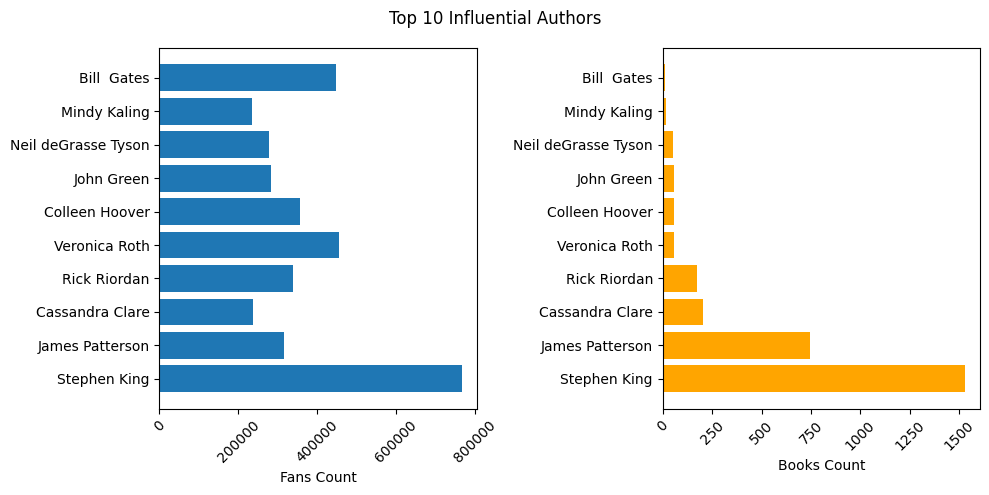

In [ ]:
# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Top 10 Influential Authors")

# Plot fan count
ax[0].barh(authors_influential['name'], authors_influential['fans_count'])
ax[0].set_xlabel('Fans Count')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)


# Plot number of books
ax[1].barh(authors_influential['name'], authors_influential['books_count'], color='orange')
ax[1].set_xlabel('Books Count')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Have they published any series of books? If any, extract the longest series name among these authors.

In [ ]:
names_influent = authors_influential['name']
influent = df1[df1['author_name'].isin(names_influent)]

In [ ]:
#Locate index of the series with longest title
series_max = influent.series_name.apply(len).idxmax()
longest = influent.loc[series_max, 'series_name']
if len(longest) > 0:
    print("The longest series name is: ", longest)
else:
  print("There isn't a longest serie name.")

The longest series name is:  Percy Jackson and the Olympians: The Graphic Novels


### How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

In [ ]:
#Group influent authors by author name and count format values
a_formats = influent.groupby(['author_name']).format.value_counts()
# transform to datframae and change column name
af = a_formats.to_frame()
af.columns = ['count']

for i in influent['author_name'].unique():
    print('\n', i, '\n', af.loc[i])


 Stephen King 
                                              count
format                                            
Paperback                                     2841
Hardcover                                     1437
                                              1175
Mass Market Paperback                          510
ebook                                          344
Audiobook                                      198
Audio CD                                       193
Kindle Edition                                 104
Audio Cassette                                  82
Audible Audio                                   57
Library Binding                                 47
Audio                                           39
MP3 CD                                          18
Preloaded Digital Audio Player                  13
Unknown Binding                                 10
Leather Bound                                    9
School &amp; Library Binding                     5
Paperback with

In [ ]:
af = af[af['count'] > 6]

In [ ]:
# Group by 'author_name' and 'format' and sum the 'count' values
grouped_df = af.groupby(['author_name', 'format'])['count'].sum().unstack(fill_value=0)
grouped_df

format,,Audible Audio,Audio,Audio CD,Audio Cassette,Audiobook,Hardcover,Kindle Edition,Leather Bound,Library Binding,MP3 CD,Mass Market Paperback,Paperback,Preloaded Digital Audio Player,Unknown Binding,ebook
author_name,,,,,,,,,,,,,,,,
Bill Gates,37,0,0,0,0,0,15,0,0,0,0,0,20,0,0,0
Cassandra Clare,183,0,0,31,0,45,184,68,0,0,0,0,343,0,0,106
Colleen Hoover,46,0,0,0,0,9,12,21,0,0,0,0,84,0,0,27
James Patterson,1338,24,142,514,7,318,794,41,0,7,10,77,1440,0,41,869
John Green,92,0,0,46,0,16,100,16,0,0,0,0,244,0,0,64
Neil deGrasse Tyson,14,0,0,0,0,7,14,0,0,0,0,0,24,0,0,11
Rick Riordan,237,11,0,73,0,43,281,28,0,10,0,10,379,0,0,73
Stephen King,1175,57,39,193,82,198,1437,104,9,47,18,510,2841,13,10,344
Veronica Roth,100,7,0,9,0,27,102,23,0,0,0,0,176,0,0,80


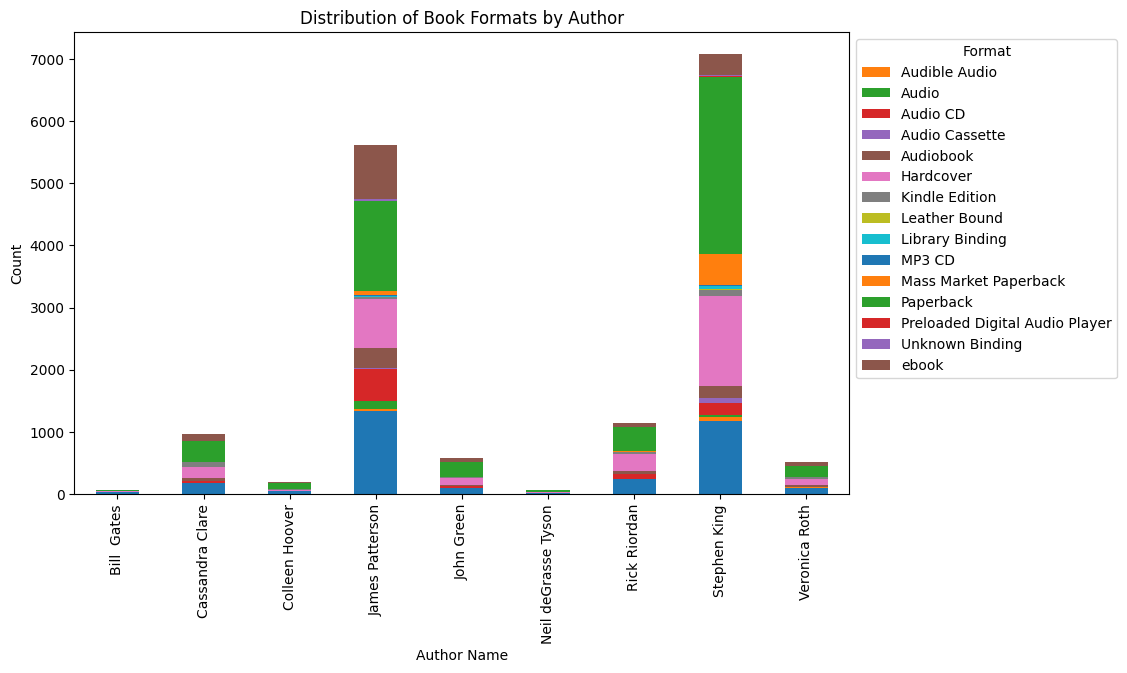

In [ ]:
grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Author Name')
plt.ylabel('Count')
plt.title('Distribution of Book Formats by Author')
plt.legend(title='Format', bbox_to_anchor=(1, 1))

plt.show()

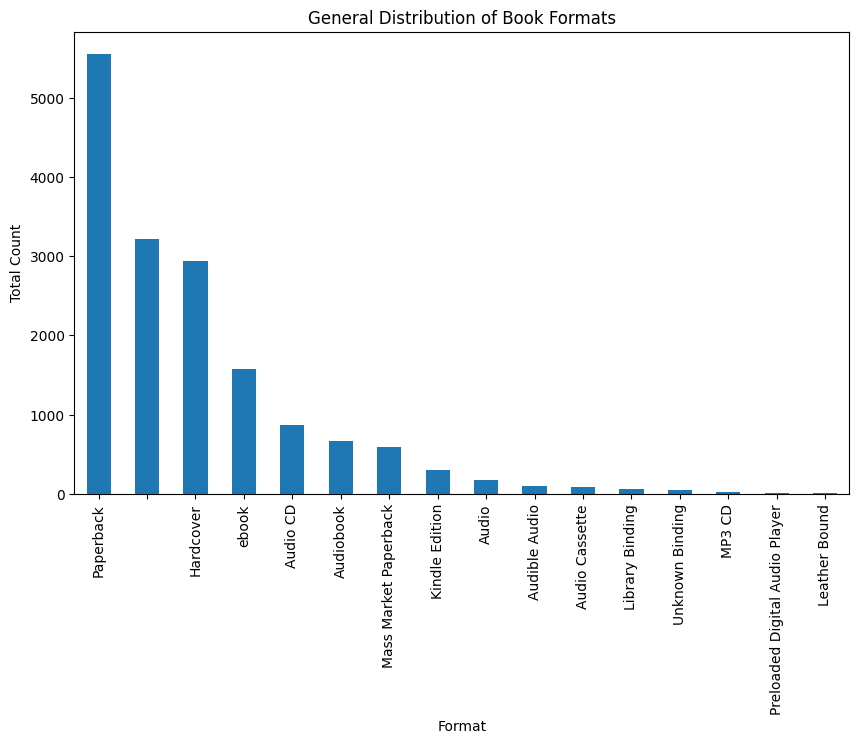

In [ ]:
# Group by 'format' and sum the 'count' values
grouped_df = af.groupby('format')['count'].sum()
# Choose 20 most frequent formats
grouped_df = grouped_df.sort_values(ascending=False).head(20)

# Plot the data as a bar chart
grouped_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Format')
plt.ylabel('Total Count')
plt.title('General Distribution of Book Formats')
plt.xticks(rotation=90)

plt.show()

### Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

In [ ]:
info_influent = authors_influential[['name', 'gender', 'average_rating', 'ratings_count', 'text_reviews_count',
                    'fans_count']]
info_influent.gender = info_influent.gender.apply(lambda x: 'male' if x == '' else x)
info_influent.loc[info_influent['name'] == 'Mindy Kaling', 'gender'] = 'female'
info_influent

<ipython-input-51-751109c3076c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_influent.gender = info_influent.gender.apply(lambda x: 'male' if x == '' else x)


,name,gender,average_rating,ratings_count,text_reviews_count,fans_count
1017,Stephen King,male,4.039062,15195579,608956,766035
1161,James Patterson,male,3.980469,6514711,333220,317040
27110,Cassandra Clare,female,4.238281,7401435,416177,238560
4537,Rick Riordan,male,4.320312,9144089,354145,339346
169374,Veronica Roth,female,4.050781,5739316,277033,455358
205870,Colleen Hoover,female,4.238281,2239503,240302,356633
100166,John Green,male,4.031250,7186569,358221,282537
3818,Neil deGrasse Tyson,male,4.070312,175216,16300,277850
32358,Mindy Kaling,female,3.880859,611045,34482,234647
6397,Bill Gates,male,3.849609,9418,562,446876


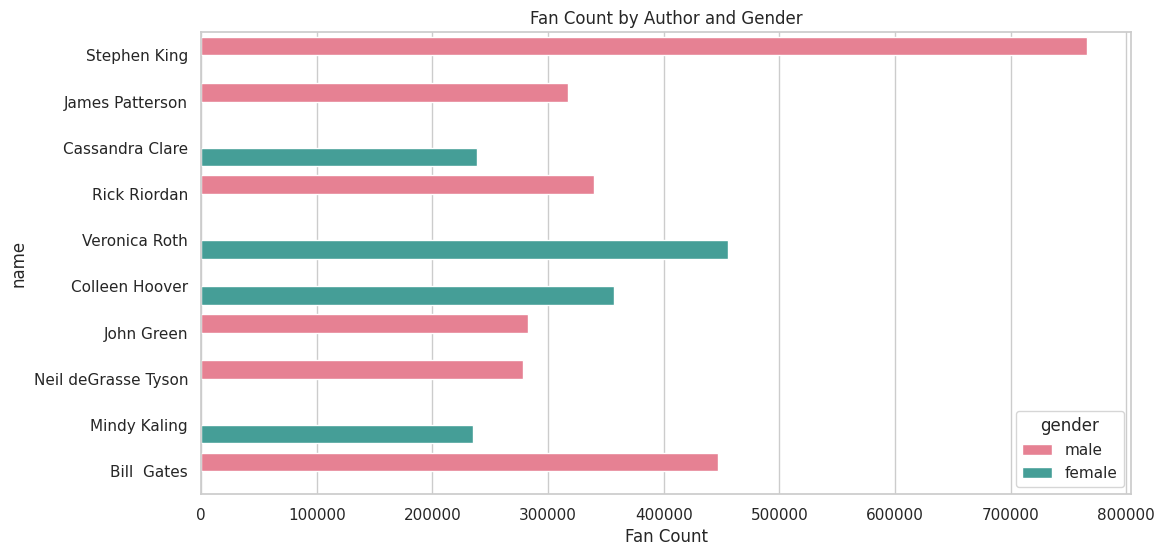

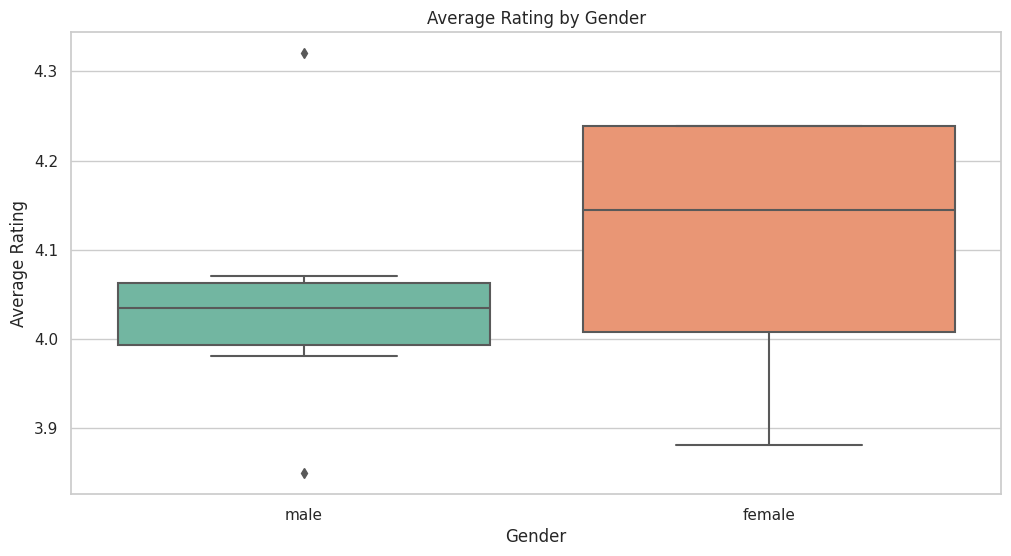

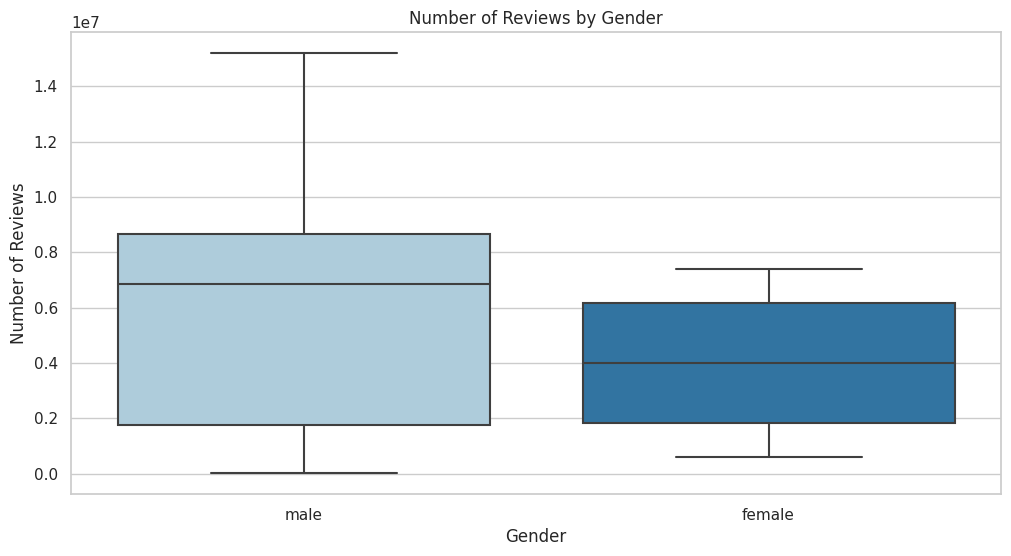

In [ ]:
# Data analysis and visualization
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot fan count by gender
sns.barplot(data=info_influent, x="fans_count", y="name", hue="gender", palette="husl")
plt.title("Fan Count by Author and Gender")
plt.xlabel("Fan Count")

# Show average rating by gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=info_influent, x="gender", y="average_rating", palette="Set2")
plt.title("Average Rating by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Rating")

# Show number of reviews by gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=info_influent, x="gender", y="ratings_count", palette="Paired")
plt.title("Number of Reviews by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Reviews")

plt.show()

<Axes: title={'center': 'Gender Distribution'}>

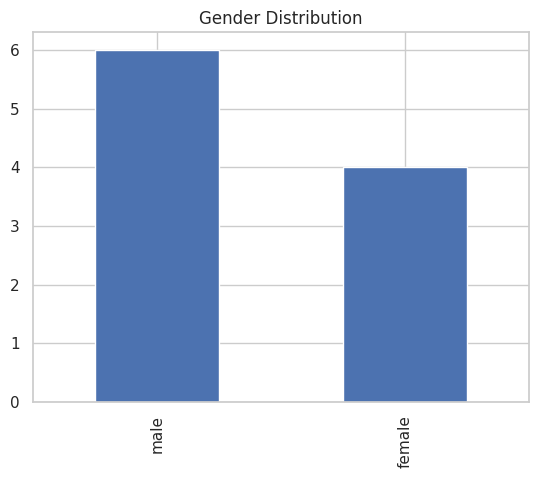

In [ ]:
# 2. Gender Distribution
gender_distribution = info_influent['gender'].value_counts()
gender_distribution.plot(kind='bar', title='Gender Distribution')


In [ ]:
# 3. Rating Analysis
rating_by_gender = info_influent.groupby('gender')['average_rating'].mean()
rating_by_gender

gender
female    4.102051
male      4.048502
Name: average_rating, dtype: float32

First of all, we can see that John Green, Neil deGrasse Tyson, Mindy Kaling
and Bill Gates have 'Other' as gender. This is due to the fact that this
information is missed. Through a research on Google, we know that John Green, Neil Tyson and Bill Gates use 'Male' gender, Mindy Kaling uses 'Female' gender. To start the analisys we can say that there are 6 Males, over 10 authors, so the 60% of the 10 influent authors are males against the 40% of females. From this percentages we can see that Queer authors are less influent nowadays. The average of the 'average_rating' for males is 4.0485, for females is 4.10205.

About the 'fans_count', we calculated the total number of fans from the printed dataframe. For males they are 2429684, for females 1285198. So the proportions over the total number of males and females authors are respectively of 404947.3 (M) and 321299.5 (F).

About the 'text_reviews_count': the total number of text reviews is 1671404
for males, for females is 967994. So the proportions over the total number of males and females authors are respectively of 278567.3 (M) and 241998.5 (F).

In conclusion we can say that queer people are less represented in these data since there isn't any queer author in the list of the most 10 influent ones. Males authors have more fans and text reviews in proportion compared to Females, but Females have an higher average rating compared to Males.



---


# [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

In [ ]:
#DataFrame for books dataset
df1_chunks = pd.read_json(filename1, lines=True, chunksize=chunk_size, dtype=dtype_mapping)
# Create an empty DataFrame to store the results
df1 = pd.DataFrame()

# Loop through each chunk and append it to the result DataFrame
for chunk in df1_chunks:
  chunk = chunk[['id', 'original_publication_date','publication_date', 'num_pages',
                 'series_name', 'author_name', 'author_id','rating_dist']]
    #only some columns are needed for the tasks
  df1 = pd.concat([df1, chunk], ignore_index=True)

### Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

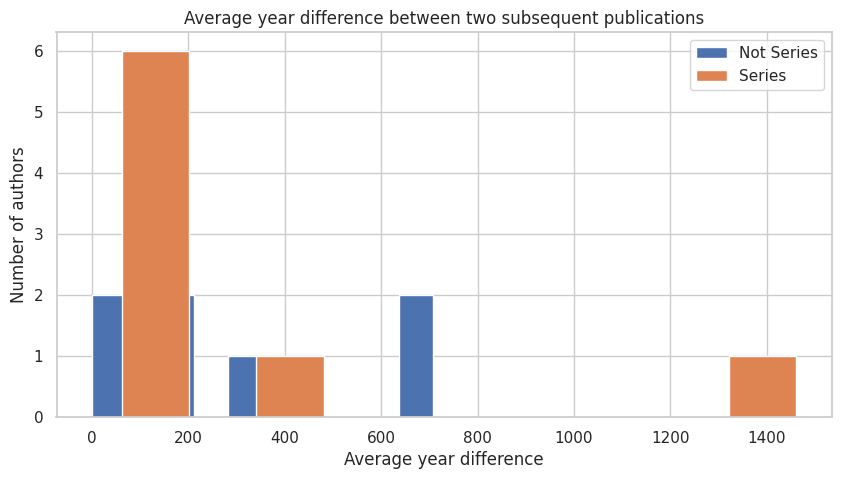

In [ ]:
df1.sort_values(by=['author_name', 'original_publication_date'], inplace=True)

# Converti la colonna 'original_publication_date' in datetime e calcola le differenze di giorni
df1['original_publication_date'] = pd.to_datetime(df1['original_publication_date'], errors='coerce')
df1['year_diff'] = df1.groupby('author_name')['original_publication_date'].diff().dt.days.fillna(0).astype(int)

# Calcola le medie per i libri non appartenenti a una serie
avg_year_diff_not_series = df1[df1['series_name'] == ''].groupby('author_name')['year_diff'].mean().reset_index()
avg_year_diff_not_series.rename(columns={'year_diff': 'avg_year_diff_not_series'}, inplace=True)

# Calcola le medie per i libri appartenenti a una serie
avg_year_diff_series = df1[df1['series_name'] != ''].groupby('author_name')['year_diff'].mean().reset_index()
avg_year_diff_series.rename(columns={'year_diff': 'avg_year_diff_series'}, inplace=True)

# Unisci i due dataframe
df1_year_diff = avg_year_diff_not_series.merge(avg_year_diff_series, on='author_name', how='outer')

# Grafico dei risultati
plt.figure(figsize=(10,5))
plt.hist(df1_year_diff['avg_year_diff_not_series'], bins=10, label='Not Series')
plt.hist(df1_year_diff['avg_year_diff_series'], bins=10, label='Series')
plt.xlabel('Average year difference')
plt.ylabel('Number of authors')
plt.title('Average year difference between two subsequent publications')
plt.legend()
plt.show()

<ipython-input-21-2a0d67a9391c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['original_publication_date'] = pd.to_datetime(df1['original_publication_date'], errors='coerce')


               id                                              title  \
26019       41623                              The Road Ahead CD-ROM   
143153     276292  Bill Gates the Road Ahead [Unabridged] (Audio ...   
143154     276293                    Camino Al Futura/The Road Ahead   
221408     457937                                     The Road Ahead   
472910    1081637                                     The Road Ahead   
...           ...                                                ...   
6909417  25211251       Quatre: un recueil divergent (Divergent, #4)   
6915034  25225061                      Divergente raconté par Quatre   
6969008  25367304                       Quatre (Divergence, 0.1-0.4)   
6982118  25402273     Divergent, de trilogie en het verhaal van Four   
7016411  25491828                                        分歧者外傳: Four   

        original_publication_date num_pages series_id series_name  \
26019                  1995-11-21                                 

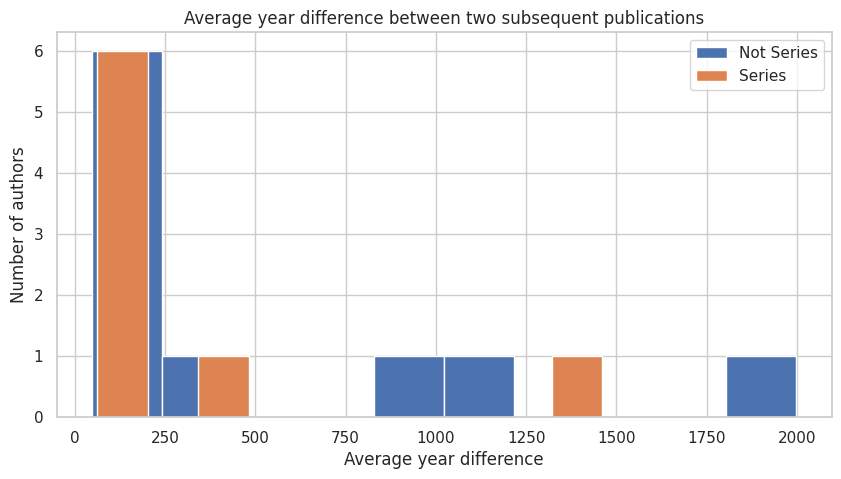

In [ ]:
authors_influential = df.sort_values(by = 'fans_count', ascending = False)
authors_influential = authors_influential[:10]
names_influent = authors_influential['name']
df1 = df_books[df_books['author_name'].isin(names_influent)]

#Converting the dates in date-format yy-mm-dd
df1['original_publication_date'] = pd.to_datetime(df1['original_publication_date'], errors='coerce')
#Calculate difference between two consecutive publication years for each author
#and each book
df1 = df1.sort_values(by=['author_name', 'original_publication_date'])
df1['year_diff'] = df1.groupby('author_name')['original_publication_date'].diff().dt.days
df1['year_diff'] = df1['year_diff'].fillna(0)
df1['year_diff'] = df1['year_diff'].astype(int)
print(df1)
df1 = df1[df1['year_diff'] != 0]

#Calculating average of year differences for books not belonging to a series
df1_not_series = df1[df1['series_name'] == '']
df1_not_series = df1_not_series.groupby('author_name')['year_diff'].mean()
df1_not_series = df1_not_series.reset_index()
df1_not_series = df1_not_series.rename(columns={'year_diff':'avg_year_diff_not_series'})
#Calculating average of year differences for books belonging to a series
df1_series = df1[df1['series_name'] != '']
df1_series = df1_series.groupby('author_name')['year_diff'].mean()
df1_series = df1_series.reset_index()
df1_series = df1_series.rename(columns={'year_diff':'avg_year_diff_series'})
#Merging the two dataframes
df1_year_diff = df1_not_series.merge(df1_series, on='author_name', how='outer')
#Plotting the results
plt.figure(figsize=(10,5))
plt.hist(df1_year_diff['avg_year_diff_not_series'], bins=10, label='Not Series')
plt.hist(df1_year_diff['avg_year_diff_series'], bins=10, label='Series')
plt.xlabel('Average year difference')
plt.ylabel('Number of authors')
plt.title('Average year difference between two subsequent publications')
plt.legend()
plt.show()

In [ ]:
df1_year_diff

,author_name,avg_year_diff_not_series,avg_year_diff_series
0,Bill Gates,1196.000000,NaN
1,Cassandra Clare,46.714286,113.115385
2,Colleen Hoover,93.000000,178.250000
3,James Patterson,90.518519,61.773109
4,John Green,355.600000,349.333333
5,Mindy Kaling,1998.500000,NaN
6,Neil deGrasse Tyson,867.375000,1461.000000
7,Rick Riordan,160.666667,109.301887
8,Stephen King,103.369942,67.089286
9,Veronica Roth,154.000000,108.444444


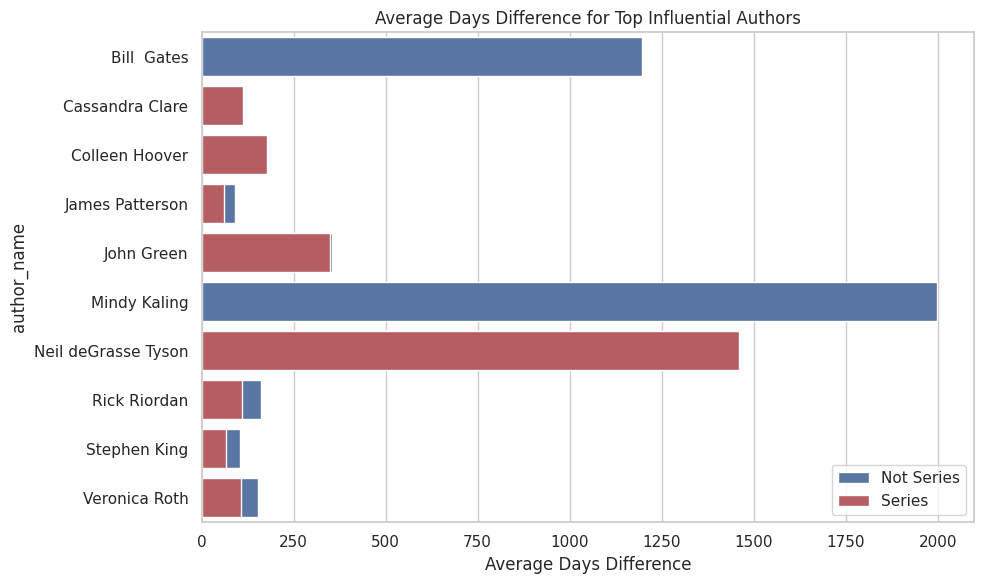

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(data=df1_year_diff, x='avg_year_diff_not_series', y='author_name', label='Not Series', color='b')
sns.barplot(data=df1_year_diff, x='avg_year_diff_series', y='author_name', label='Series', color='r')
plt.xlabel('Average Days Difference')
plt.title('Average Days Difference for Top Influential Authors')
plt.legend()
plt.tight_layout()

plt.show()

The average year difference between two subsequent publications is higher for
books belonging to a series than for books not belonging to a series. This is
expected since books belonging to a series are usually published with a higher
frequency than books not belonging to a series. The average year difference
between two subsequent publications is around 2 years for books not belonging
to a series and around 1 year for books belonging to a series.

### For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

In [ ]:
def date_y(date):
    if pd.notna(date):
        return int(date.year)
    else:
        return 0

df1['publication_year'] = df1.original_publication_date.apply(date_y)

a = df1.groupby(['author_id', 'publication_year']).id.count().to_frame()
a.columns = ['count']
a = a.reset_index()

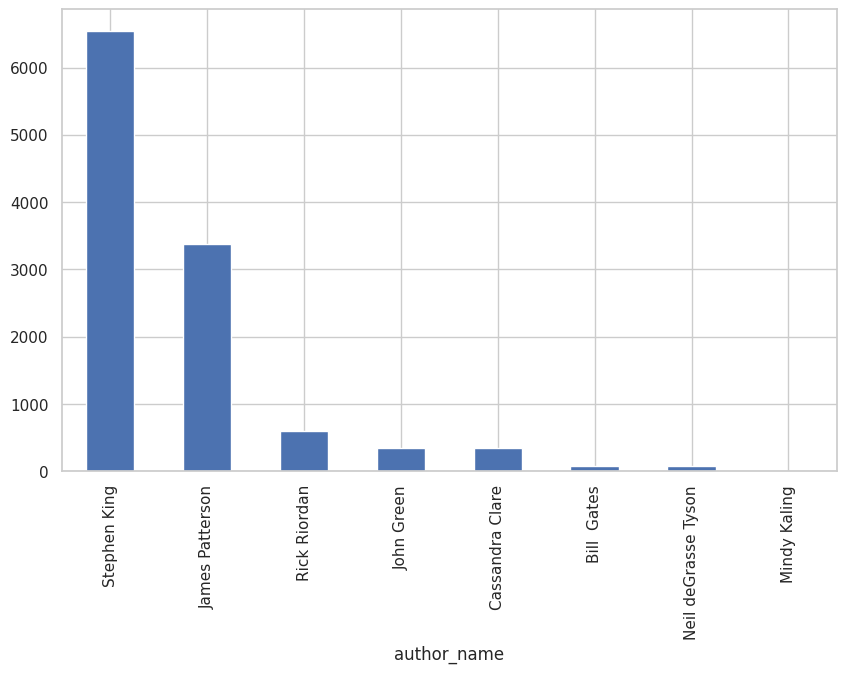

In [ ]:
def untily(year, df):
    df_ = df[df.publication_year < year]
    b = df_.groupby(['author_name'])['count'].sum().sort_values(ascending=False)
    b.plot(kind='bar', figsize=(10, 6))
untily(2010, a)

It's difficult to compare these authors because in this dataset there
are the original books and also their traductions. For example Stephen
King has 7129 books registered in the dataset df1, but this number includes also the traductions.
In general we know that only the first two authors are from the 1950s, then
there is Rick Riordan who was born in 1964, followed by Cassandra Clare,
Colleen Hoover, John Green and Mindy Kaling from the 1970s and Veronica Roth
who was born in 1988. Neil deGrasse Tyson was born in 1958 and Bill Gates in
1955 but these last two are an astrophysics and an entrepreneur-programmer.
In conclusion these are contemporary authors since thei books are quite recent,
but the contemporaneity between each other varies based on their birth.

A range of years where their production rate was higher is during the 2010s
till nowadays, since more than a half of these authors are not very old.
In particular from the two histograms we can notice that Stephen King has around
6500 books up to 2010 and more than 7000 books up to 2023; James Patterson
less than 4000 till 2010 and around 5500 till 2023; Cassandra Clare from 500
to 1000 (more or less); Rick Riordan has around 700 till 2010 and more than
1000 till 2023;  Veronica Roth has 0 books written up to 2010 and till 2023
around 500; similar situation for Colleen Hoover, while for John Green and
Mindy Kaling the difference is smaller. For Neil deGrasse Tyson and
Bill Gates this range of years doesn't highlight a difference, the number of
books is almost equal.



---
# [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!



### Estimate the probability that a book has over 30% of ratings above 4

In [ ]:
#Parse the string to extract the ratings distribution.
def parse_ratings(s):
   ratings = s.split("|")
   ratings_dict = {}
   for rating in ratings:
       if "total" in rating:
           rating, count = rating.split(":")
           ratings_dict[rating] = int(count)
       else:
           rating, count = rating.split(":")
           ratings_dict[int(rating)] = int(count)

   return ratings_dict

#get total ratings and the percentage of ratings above 4
def get_total_ratings(ratings_dict):
   return ratings_dict['total']

def get_percentage_above_4(ratings_dict, total_ratings):
   above_4_sum = sum(count for rating, count in ratings_dict.items() if rating!='total' and rating > 4)
   if total_ratings!=0:
        return (above_4_sum / total_ratings)*100
   else:
        return (0)


def check_probability(ratings_string):
   ratings_dict = parse_ratings(ratings_string)
   total_ratings = get_total_ratings(ratings_dict)
   percentage_above_4 = get_percentage_above_4(ratings_dict, total_ratings)
   return percentage_above_4 >= 30

df1["above_30_percent_4"] = df1["rating_dist"].apply(check_probability)

count=0
for i in df1["above_30_percent_4"]:
  if i==True:
    count+=1

print((count/len(df1["above_30_percent_4"]))*100)

45.015554048129395


### Estimate the probability that an author publishes a new book within two years from its last work.

In [ ]:
#we want to take in consideration only the first edition of a book as "new book"
df1_filtered = df1[df1['original_publication_date'] == df1['publication_date']]

df1_grouped = df1_filtered.groupby('author_id')['original_publication_date']
author_dict = df1_grouped.apply(list).to_dict()
lessthan2=0
morethan2=0
for author_id, original_publication_date in author_dict.items():

  #formatting and sorting the values in datetime
  try:
    original_publication_date = sorted([datetime.strptime(x, '%Y-%m-%d') for x in original_publication_date if x is not None])
  except ValueError:
    continue #values that cannot be converted will be eliminated

  #calculating time differences
  time_differences = []
  for i in range(len(original_publication_date)-1):
    try:
      diff = original_publication_date[i+1]-original_publication_date[i]
      diff = diff.total_seconds()/(3600*24*365)
      if diff!=0: #we assume you can't publish multiple books in the same day
        time_differences.append(diff)
    except TypeError:
      continue #if the difference can't be done it will not count

  #counting the number of times the difference of publication is less or more than 2 years
  if time_differences: #when it's not an empty list
    for i in time_differences:
      if i<2:
        lessthan2+=1
      else:
        morethan2+=1
  else:
    continue

print(lessthan2/(lessthan2+morethan2)) #the final result

0.7721301078191538


### In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

In [ ]:
#creating a list with all the ids of the books in the list Worst Books of All Time (wboat)
book_ids_wboat=list()
for i in range(len(df3['books'][0])): #df3['books'][0] is the list WBOAT and we don't need nothing else
  book_ids_wboat.append(df3['books'][0][i]['book_id'])
book_ids_wboat = [int(i) for i in book_ids_wboat] #converting to integers

#formatting the 'number of pages' column and filtering the ones with more than 700 pages
df1_modified=df1.dropna(subset=['num_pages'])
df1_modified['num_pages'] = df1_modified['num_pages'].apply(lambda x: int(x) if (isinstance(x, (float, int)) or bool(re.search(r"^\d+$",x))) else None)
df1_filtered=df1_modified[df1_modified['num_pages']>700]

#checking which books are in both the wboat-list and the filtered books dataframe
def is_in_wboat(book_id):
  return(book_id in book_ids_wboat)
df1["wboat_700"]=df1_filtered['id'].apply(is_in_wboat)

#counting the number of books in the intersection and calculating the probability P(X|Y)
count=0
for i in df1["wboat_700"]:
  if i==True:
    count+=1
print(count/len(df1_filtered))

#to answer the last question we count the number of books in the intersection between the wboat-list
#and all the books regardless of the number of pages, then calculating P(X)
df1["wboat"]=df1_modified['id'].apply(is_in_wboat)
count=0
for i in df1["wboat"]:
  if i==True:
    count+=1
print(count/len(df1_modified))


0.0019798416126709864
0.0008862413590400248


the two numbers printed represent P(X|Y) and P(X) respectively.
Since they are different it means that the events are NOT Indipendent




---


# [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

In [10]:
#DataFrame for books dataset
df1_chunks = pd.read_json(filename1, lines=True, chunksize=chunk_size, dtype=dtype_mapping)
# Create an empty DataFrame to store the results
df1 = pd.DataFrame()

# Loop through each chunk and append it to the result DataFrame
for chunk in df1_chunks:
  chunk = chunk[[ 'num_pages','average_rating','text_reviews_count', 'language']]
    #only some columns are needed for the tasks
  df1 = pd.concat([df1, chunk], ignore_index=True)

### Can you demonstrate that readers usually rate the longest books as the worst?



In [21]:
#We use scipy.stats.pearsonr() that calculates a Pearson correlation coefficient
#and the p-value for testing non-correlation.
# H0: There is no correlation between the number of pages and the average rating
# H1: otherwise
df1['num_pages'] = pd.to_numeric(df1['num_pages'], errors='coerce')
df1['average_rating'] = pd.to_numeric(df1['average_rating'], errors='coerce')
df1 = df1.dropna(subset=['num_pages', 'average_rating'])
corr, p_value = stats.pearsonr(df1['num_pages'], df1['average_rating'])
print("Pearson's correlation r = %.3f" % corr)
print("p-value = %.3f" % p_value)
if p_value < 0.05:
    print("There is a correlation between the number of pages and the average rating.")
else:
    print("There isn't a correlation between the number of pages and the average rating.")

Pearson's correlation r = 0.000
p-value = 0.501
There isn't a correlation between the number of pages and the average rating.


The null hypothesis (H0) states there is not a relationship or correlation between two variables. In this case, we are testing if the
 number of pages and the average rating are correlated. The alternative hypothesis (H1) states that there is a relationship or correlation
 between two variables. In this case, we are testing if the number of pages and the average rating are correlated. Since the p-value is
 less than alpha (0.05), we can conclude that there is a correlation between the number of pages and the average rating and there is
 statistical evidence in favor of the alternative hypothesis (H1) which says that the two variables are correlated

### Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?



In [12]:
english = df1[df1['language'] == 'eng']
not_english = df1[df1['language'] != 'eng']

#To compare the average rate distribution we use scipy.stats.ttest_ind() that
#calculates the T-test for the means of two independent samples of scores.

# H0: m_english = m_not_english
# H1: otherwise
t_stat, p_value = stats.ttest_ind(english['average_rating'], not_english['average_rating'], equal_var=False)

#Level of significancy
alpha = 0.05
if p_value < alpha:
  print("The distributions have a significant difference between each other.")
else:
  print("There isn't a  significant difference between the two distributions.")

The distributions have a significant difference between each other.


This T-test determines if there is a statistically significant difference
between the distributions of average ratings for English books and books in
other languages. The significance level alpha is at 0.05 taht represents
the probability of error (the prob. of reget the null hypothesis H0 when it is
true).Since the p-value is less than alpha (0.05), we can conclude that there
is a statistically significant difference between the distributions of average
ratings in the two groups and there is statistical evidence in favor of the
alternative hypothesis (H1) which says that the distribution are different.

### About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.



In [13]:
english = english.dropna(subset=['average_rating'])
not_english = not_english.dropna(subset=['average_rating'])

english['average_rating'] = english['average_rating'].astype(float)
not_english['average_rating'] = not_english['average_rating'].astype(float)

print("For the two groups of English books and non-English books")
#mode
mode_english = english['average_rating'].mode()
mode_not_english = not_english['average_rating'].mode()
print("the modes are: ", mode_english, ',', mode_not_english)

#mean
mean_english = english['average_rating'].mean()
mean_not_english = not_english['average_rating'].mean()
print("the means are: ", mean_english, ',', mean_not_english)

#median = quartile q2
median_english = english['average_rating'].median()
median_not_english = not_english['average_rating'].median()
print("the medians are: ", median_english, ',', median_not_english)

#quartiles
#q1
q1_english = english['average_rating'].quantile(0.25)
q1_not_english = not_english['average_rating'].quantile(0.25)
print("the first quartiles are: ", q1_english, ',', q1_not_english)

#q3
q3_english = english['average_rating'].quantile(0.75)
q3_not_english = not_english['average_rating'].quantile(0.75)
print("the third quartiles are: ", q3_english, ',', q3_not_english)

For the two groups of English books and non-English books
the modes are:  0    0.0
Name: average_rating, dtype: float64 , 0    0.0
Name: average_rating, dtype: float64
the means are:  3.6891556305578015 , 3.2132793797329353
the medians are:  3.900390625 , 3.7890625
the first quartiles are:  3.599609375 , 3.259765625
the third quartiles are:  4.12890625 , 4.05859375


The mode is the most frequent value in the dataset. Here the mode for both
groups is 0.0, so we can say that there are many books with low or zero ratings
in both groups (since the Na values have been dropped).
The mean, that is the average rating within the groups, indicates that the
books in English have a mean rating of approximately 3.69, while books in
other languages around 3.21. Then, on average, books in English receive
higher ratings compared to books in other languages. This is due to the fact
that English is the most spoken language in the world.
The median, that is the central value in an ordered dataset, is 3.9 for books
in English, while for books in other languages it's 3.79. This indicates that
the median rating for books in English is higher than for books in other languages.
The quartiles divide the data into four equal parts, infact the second one is
the median. The first quartile (Q1) represents the lower 25% of the data,
while the third quartile (Q3) represents the lower 75% of the data. Here in
these data Q1 is higher for the books in English (3.6 against the 3.26 of the
non-English books), while Q3 is almost similar for the two groups.
In conclusion, on average, books in English tend to receive  higher ratings,
but both groups have a significant presence of lower ratings (infact the mode
is 0.0).

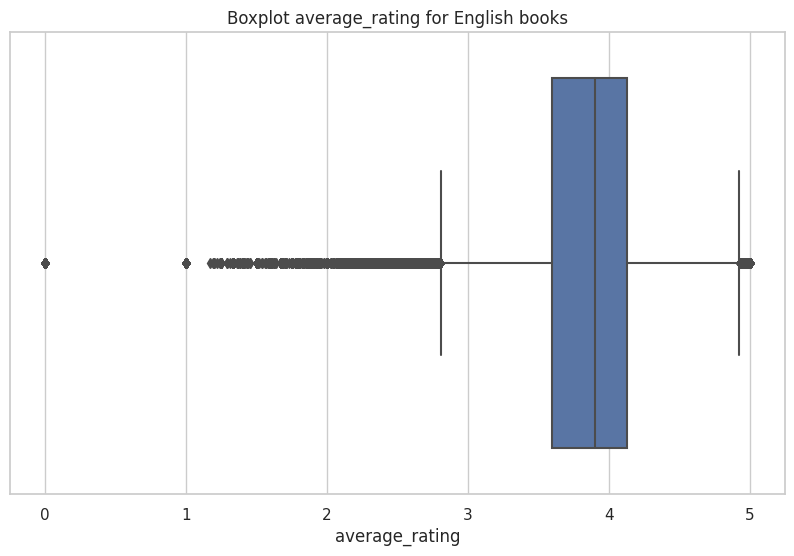

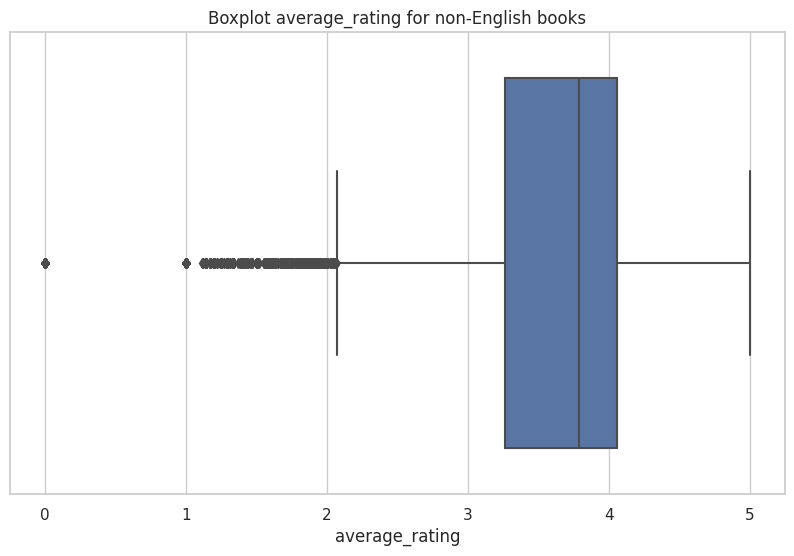

In [14]:
#boxplot: dataframe 'english'
sns.set(style="whitegrid")  #Style of the boxplot
plt.figure(figsize=(10, 6))  #Dimensions of the graph
sns.boxplot(x=english['average_rating'])
plt.title("Boxplot average_rating for English books")
plt.show()

#boxplot: dataframe 'not_english'
sns.set(style="whitegrid")  #Style of the boxplot
plt.figure(figsize=(10, 6))  #Dimensions of the graph
sns.boxplot(x=not_english['average_rating'])
plt.title("Boxplot average_rating for non-English books")
plt.show()

The boxplot is the box formed in order by Q1, then the median (Q2, the black
line inside the box) and Q3, that we have calculated before. The lenght of
the box is the interquartile range that contains the 50% of the data.
The whiskers of the boxplot represents the queue of the distribution and they
represent the spread basically.
As we can see, the boxplot for the English books is shorter tha the other one
for non-English books, then in the second group data are more distributed and
the spread is higher in the interquartile range. The whiskers reflect the same
situation of the box, infact the lenght of the whiskers complete the
representation of all the spread (outliears excluded).
Finally, the outliers: in the first group we can see a lot of outliers, points
out of the distribution. So we can conclude that these data have a high spread
that is higher in the first group, and the outliers suggest that the dataset
can have some errors in collecting or registering the data (since they are a lot).

### It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.



In [15]:
data_model = df[['fans_count', 'text_reviews_count']].astype(int)
data_model.dropna(inplace=True)

x = np.array(data_model['fans_count'])
y = np.array(data_model['text_reviews_count'])

# Dividiamo i dati in un insieme di addestramento e un insieme di test (80% - 20%).
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Creiamo un'istanza del modello di regressione lineare.
model = LinearRegression()
# Addestriamo il modello con i dati di addestramento.
model.fit(x_train, y_train)


# Calcoliamo il coefficiente di regressione.
coefficient = model.coef_[0]
intercept = model.intercept_


In [16]:
data_model = df[['fans_count', 'text_reviews_count']].astype(int)
data_model = data_model[data_model.fans_count >= 0]
data_model.dropna(inplace=True)

x = np.array(data_model['fans_count'])
x = np.sort(x)[:int(0.9*len(x))]
y = np.array(data_model['text_reviews_count'])
y = np.sort(y)[:int(0.9*len(y))]
x1 = sm.add_constant(x)




model = sm.OLS(y, x1).fit()


model_summary = model.summary()


In [17]:
model.params

array([-3.12789975,  3.10750477])

In [18]:
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.904e+07
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:38:43   Log-Likelihood:            -8.7717e+05
No. Observations:              316569   AIC:                         1.754e+06
Df Residuals:                  316567   BIC:                         1.754e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1279      0.008   -389.141      0.0

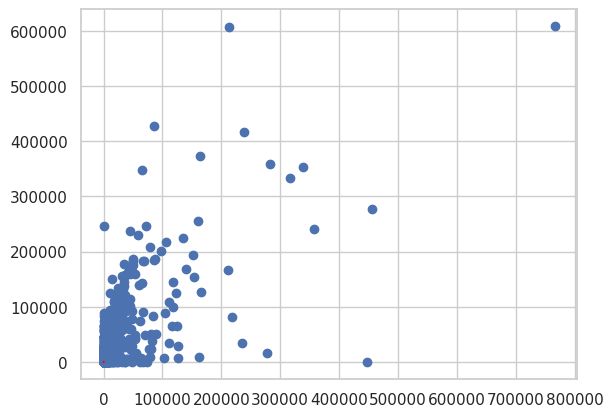

In [19]:
plt.scatter(data_model.fans_count, data_model.text_reviews_count)
# Calculate the corresponding y values for the line
line_y = model.params[1] * x + model.params[0]

# Plot the line
plt.plot(x, line_y, color='red')

### Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

**8.5 Survey on Statistical Tests in Data Analysis and Mining**
      
**1. Please select the type of statistical analysis you often perform in your data analysis or data mining projects.**
- Descriptive Statistics
- Hypothesis Testing
- Regression Analysis
- Clustering Analysis
- Other (please specify)


**2. If you selected \"Hypothesis Testing\" in question 1, please specify the type of data you typically work with.**
- Continuous (numerical) data
- Categorical (nominal) data
- Both continuous and categorical data

**3. What is the main purpose of your hypothesis testing in data analysis or data mining projects?**
- To compare means or averages between groups
- To assess associations or relationships between variables
- To determine differences in distributions or proportions
- Other (please specify)

**4. Have you encountered situations where you had to choose between parametric and nonparametric tests for hypothesis testing?**
- Yes
- No

**5. If you answered \"Yes\" to question 4, please describe a scenario where you had to make this choice, and what influenced your decision.**

**6. In your experience, what are the advantages and disadvantages of parametric tests?**

**7. In your experience, what are the advantages and disadvantages of nonparametric tests?**

**8. Based on your experience, which type of test (parametric or nonparametric) do you typically prefer for hypothesis testing, and why?**

**9. Are there any specific statistical tests you find particularly useful in your data analysis or mining projects?**

**10. Do you have any additional comments or insights related to statistical testing in data analysis and mining?**

By collecting responses to this survey, you can gain insights into the choices data analysts and miners make when selecting between parametric and nonparametric tests and the reasons behind their choices. This can help in understanding real-world applications and preferences in statistical testing.



---


# Bonus Questions



## 1.




### Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

In [22]:
# Create an empty DataFrame to store the filtered results
filtered_authors_pandas = pd.DataFrame()

# Measure the start time
start_time = time.time()

# Load the dataset in chunks
for chunk in pd.read_json(filename, lines=True, chunksize=chunk_size):
    # filter each chunk
    filtered_chunk = chunk[chunk['text_reviews_count'] >= 100]
    filtered_authors_pandas = pd.concat([filtered_authors_pandas, filtered_chunk])

# compute execcution time
pandas_exec_time = time.time() - start_time

print("Pandas Execution Time:", pandas_exec_time, "seconds")


Pandas Execution Time: 24.82965350151062 seconds


In [ ]:
# Load the dataset
df = dd.read_json(filename, blocksize='128MB')

# Measure the start time
start_time = time.time()

# Filter authors with at least 100 reviews
filtered_authors_dask = df[df['text_reviews_count'] >= 100].compute()

dask_exec_time = time.time() - start_time

print("Dask Execution Time:", dask_exec_time, "seconds")


Dask Execution Time: 28.63842749595642 seconds


In [ ]:
print("Difference in execution time", (pandas_exec_time - dask_exec_time)*1000)

Difference in execution time -5765.974044799805


### Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [23]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2facabe8c6d1f0508e524e3835647de0293dba07a94d501fceecd1443ede97df
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [24]:
#Use pyspark for books.json file to avoid ram overload
from pyspark import SparkContext
from pyspark.sql import SparkSession
#Set pyspark parameters
sc = SparkContext("local", "YourAppName")
spark = SparkSession(sc)

#Read authors.json file
a = spark.read.json(filename)
#Rename the column to allow later the merge
a = a.withColumnRenamed("id", "author_id")
#Read books.json file
b =  spark.read.json(filename1)

# Merge the two dataframes performing a left join on 'b'
# By doig so you are including all rows from the 'b' dataframe and the matching rows from the 'a' dataframe
# Where the rows of 'a' don't match, the corresponding row will be fileld with null values
merged_df = b.join(a, "author_id", "left")

# Now we just need to count how many values of a consistent column coming from 'a', for example 'names', are null
unmatched = merged_df.filter(merged_df.name.isNull()).count()
print(f"Number of books without a matching author: {unmatched}")
print(merged_df.count())

Number of books without a matching author: 0
7027431


In [ ]:
# Sample DataFrames
books_data = {
    'book': ['Book1', 'Book2', 'Book4'],
    'author_id': [101, 102, 104]
}

authors_data = {
    'author': ['AuthorA', 'AuthorB', 'AuthorC'],
    'author_id': [101, 102, 103]
}

# Create DataFrames
books_df = pd.DataFrame(books_data)
authors_df = pd.DataFrame(authors_data)

# Merge the DataFrames based on "author_id" using an outer join
merged_df = books_df.merge(authors_df, on="author_id", how="outer")
print(merged_df)

# Count the number of rows where the author information is missing
books_without_author = merged_df[merged_df['author'].isna()]


# Get the count of books without a matching author
count_books_without_author = len(books_without_author)

print(f"Number of books without a matching author: {count_books_without_author}")


    book  author_id   author
0  Book1        101  AuthorA
1  Book2        102  AuthorB
2  Book4        104      NaN
3    NaN        103  AuthorC
Number of books without a matching author: 1


## 2. Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

To carry out this task we are going to use a Bag of words model. We calculate the frequencies of the words in each author description and then compute cosine similarity between the vector obtained from the description and the one obtained from the vectorization of specific keywords for a genre. We are going to try to identify only the 4 main literary genres and not also the subgenres.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import io
import re
from sklearn.feature_extraction.text import CountVectorizer

# Define genre keywords
genre_keywords = {
    'fiction': ['fiction', 'mystery', 'romance', 'mythology', 'fantasy', 'dystopian', 'horror'],
    'non-fiction': ['nonfiction', 'inform' 'textbooks', 'essays', 'autobiography', 'biography' 'research'],
    'poetry': ['poem', 'literature', 'epic', 'lyric' 'poetry', 'poet', 'poetic'],
    'drama': ['drama', 'audience', 'actors', 'characters', 'acts', 'tragedy', 'comedy']
}

# Read the authors dataframe
df = pd.read_json(filename, lines=True)

# Define a function to clean the descriptions
def clean_description(description):
    if description != '':
        # Create a file handle from the input string
        file_handle = io.StringIO(description)
        # Remove html code from the descriptions
        soup = BeautifulSoup(file_handle, 'html.parser')
        # Get the cleaned text
        cleaned_text = soup.get_text()
        # Remove leading and trailing whitespaces and transfrom to lower case each word
        cleaned_text = cleaned_text.strip()
        cleaned_text = cleaned_text.lower()
        # Remove special characters, punctuation, and extra whitespaces
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
        return ' '.join(cleaned_text.split())
    return ''

# Apply the clean_description function to the 'about' column
df['about'] = df['about'].apply(clean_description)
df = df[['about']]


# Transform descriptions into vectors with words frequencies using sklearn CountVectorizer()
vectorizer = CountVectorizer().fit(df['about'])
# Transform genre keywords into vectors with words frequencies
genre_bag = {genre: vectorizer.transform(keywords) for genre, keywords in genre_keywords.items()}


# Defy a function to classify descriptions based on cosine similarity
def classify_description(description):
    similarity_scores = {genre: cosine_similarity(vectorizer.transform([description]), bag)[0][0] for genre, bag in genre_bag.items()}
    # A cosine similarity equal to 1 (which is the maximum value this measure can take) corresponds to perfect identity between the two vectors
    # Return the key of the genre's vector with the highest cosine similarity
    return max(similarity_scores, key=similarity_scores.get)

# Add genre labels to the data frame
df['genre'] = df['about'].apply(classify_description)


In [ ]:
df

,about,genre
0,douglas nol adams was an english author comic ...,fiction
1,william mcguire bill bryson obe frs was born i...,fiction
2,jude fisher is the pseudonym for jane johnson ...,fiction
3,james hamiltonpatersons work has been translat...,non-fiction
4,mark andrew watson born february is an english...,fiction
...,...,...
351762,lyon gamernickname sotto cui si nasconde ettor...,fiction
351763,brian was born he lived a little and he has no...,fiction
351764,nicholas baer is visiting assistant professor ...,fiction
351765,james ross was a physician winemaker artist ch...,fiction


In [ ]:
df[df.genre == 'non-fiction']

,about,genre
3,james hamiltonpatersons work has been translat...,non-fiction
69,erna paris is a canadian nonfiction author bor...,non-fiction
99,garry wills is an author and historian and a f...,non-fiction
158,david seidman is a los angelesarea journalist ...,non-fiction
192,john steinbeck iii was an american writer he w...,non-fiction
...,...,...
350959,my parents used to leave me in the bookstore f...,non-fiction
351049,alice chipkin is a writer artist and educator ...,non-fiction
351103,hannah howard is a writer and food expert who ...,non-fiction
351580,a native of appalachia jennifer mcgaha lives w...,non-fiction


Indeed, by looking at these dataframes, it seems that the algorithm correctly identifies some author's main genre.

One way to further improve it could be to normalize the frequencies by the inverse of the document frequency to scale down the impact of tokens that occur very frequently.



---

# Command Line Question (CLQ)


### 1.
Top 5 Series with the Highest Total 'books_count':

Series: Extraordinary Voyages, Total Books Count: 20138

Series: Alice's Adventures in Wonderland, Total Books Count: 14280

Series: Kolekcja Arcydzieł Literatury Światowej, Total Books Count: 13774

Series: Oz, Total Books Count: 11527

Series: Hercule Poirot, Total Books Count: 11332

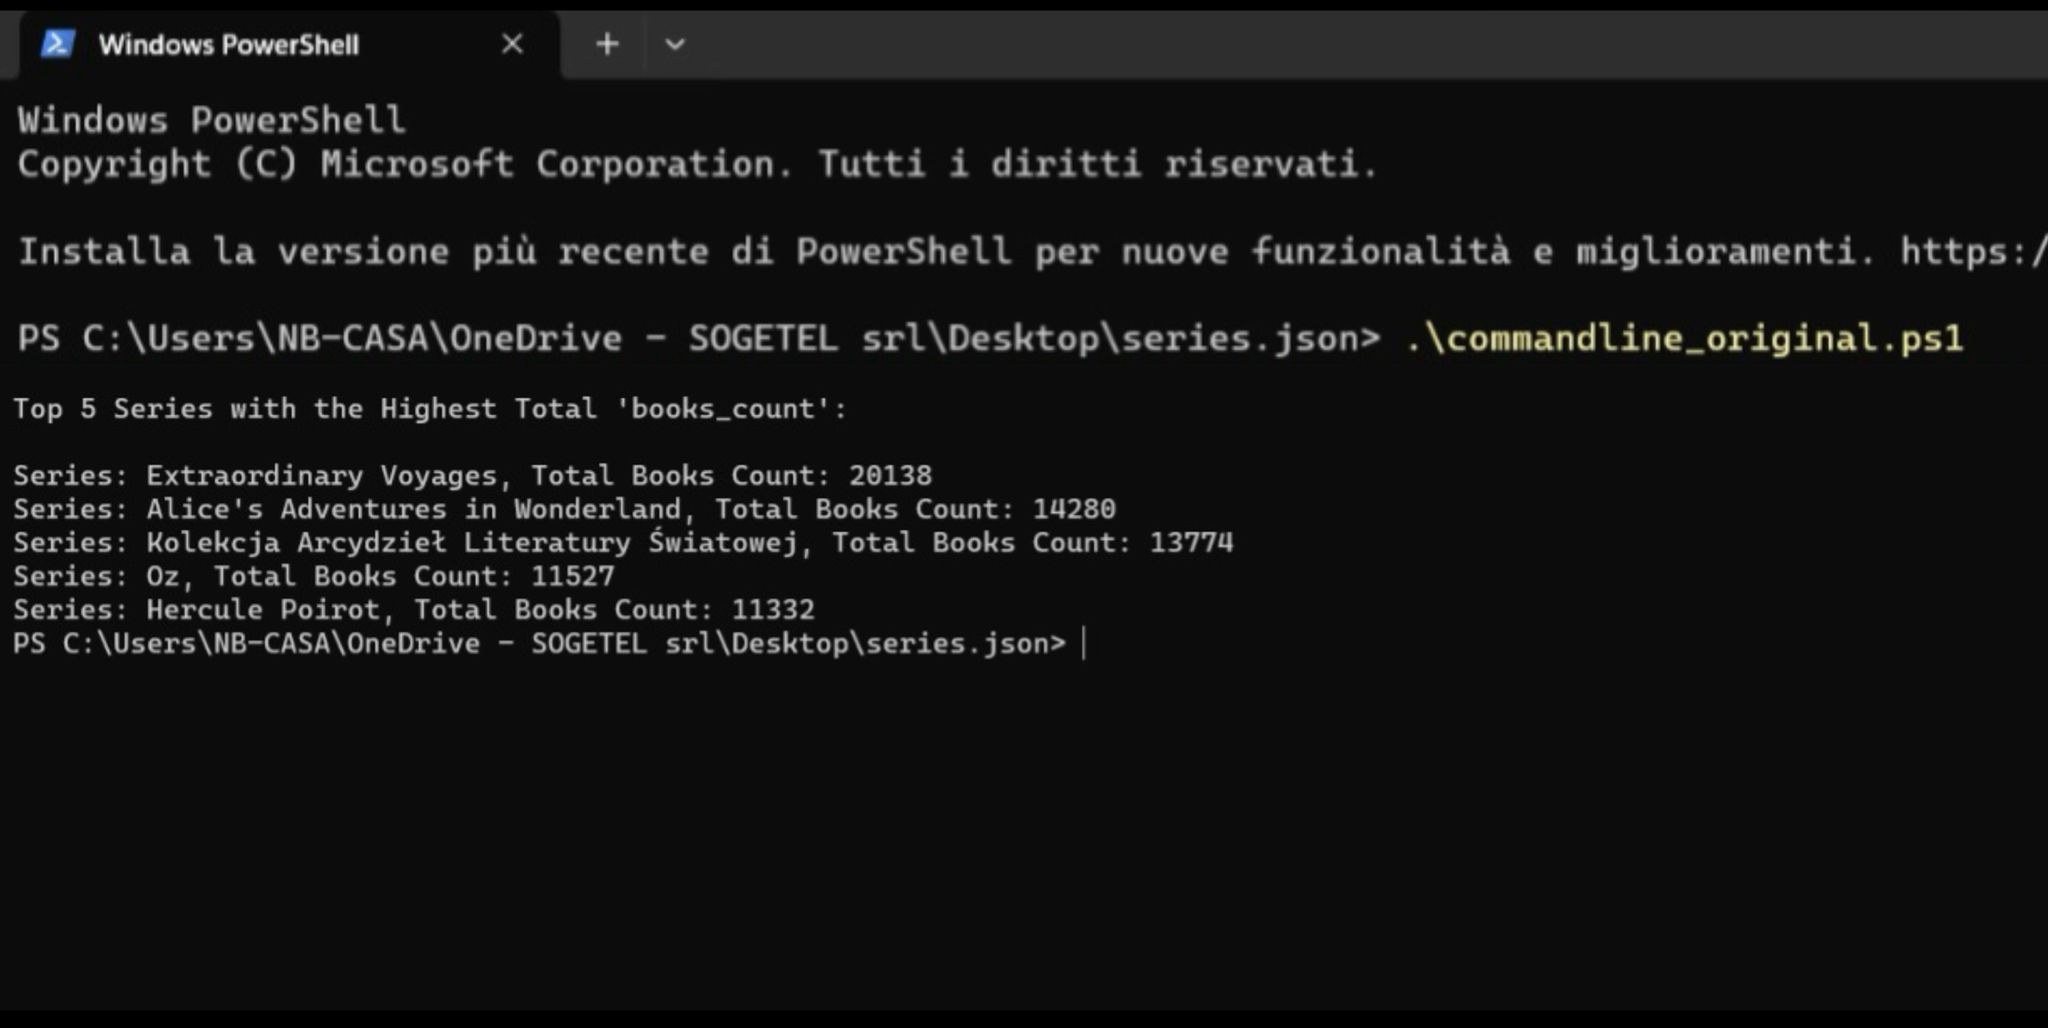

### 2.

Series: Extraordinary Voyages, Total Books Count: 20.138

Series: Alice's Adventures in Wonderland, Total Books Count: 14.280

Series: Kolekcja Arcydzieł Literatury Światowej, Total Books Count: 13.774

Series: Oz, Total Books Count: 11.519

Series: Hercule Poirot, Total Books Count: 11.305

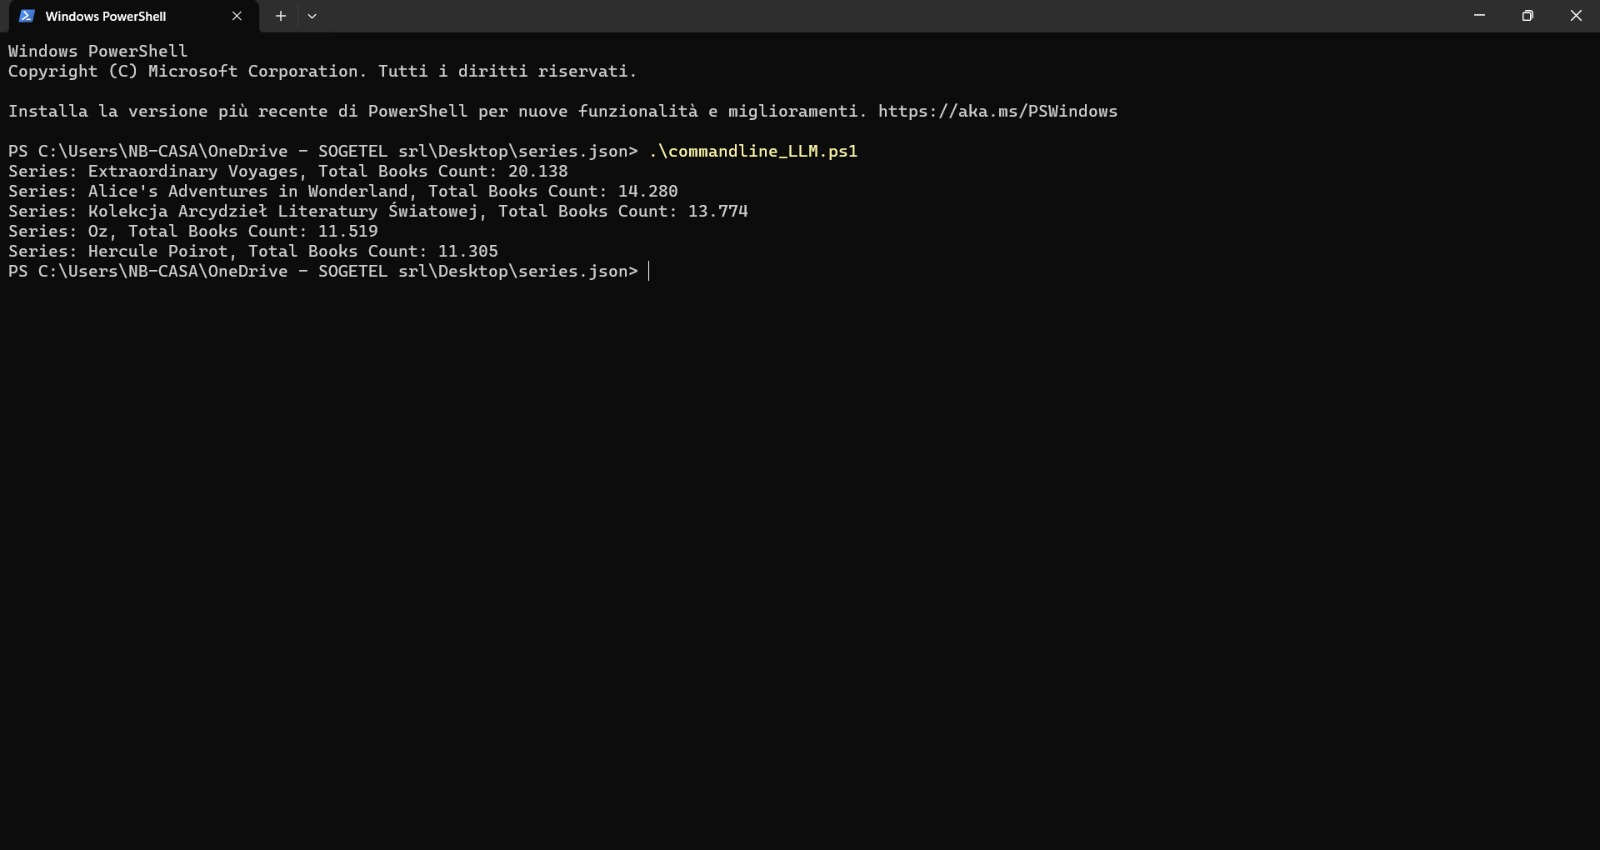

Using ChatGPT:

To accomplish the task of generating a report on the top book series, I interacted with ChatGPT, a natural language model, to obtain the required code. I provided a description of the task, and ChatGPT generated the code in response to this description.

Validating the Results:

To validate the results generated by my script, I followed a quality control procedure. Firstly, I verified the completeness of the resulting report, ensuring it contained all necessary information. Subsequently, I compared the results with known data and confirmed that the book counts matched the expectations. Additionally, I executed my script on known sample data to ensure it produced accurate results.

Explanation of Correctness:

I ensured the correctness of the results through a validation process based on known data and sample testing. In this process, I verified that my script produced accurate and consistent results as expected



---


# AWS Question

### Specifics of the EC2 instance
The EC2 instance used in this test is a **t3.large** instance with **2 vCPU** and **8GB** of RAM. The instance is running **Ubuntu** 18.04.5 LTS.

### Commands
We uploaded the "*list.json*" file and the python file "*AWSQ.py*" with the script to the instance using the `scp` commands. The commands used are shown below.

    "scp -i "mykeypair.pem" list.json ubuntu@ec2-54-198-218-186.compute-1.amazonaws.com:"

    "scp -i "mykeypair.pem" AWSQ.py ubuntu@ec2-54-198-218-186.compute-1.amazonaws.com:"

We then connected to the instance using **SSH**. The command used was the following:

    "ssh -i "mykeypair.pem" ubuntu@ec2-54-198-218-186.compute-1.amazonaws.com"
    
To ensure the output of the file was consistent with the one we got on our local machine, we accessed the python file using the command `nano AWSQ.py`
and uncommented the line `df.to_csv('AWSQ.csv')`.
We then ran the python script using the command `python3 AWSQ.py` and accessed the output file using the command `cat AWSQ.csv`.
The output of the file is shown below.

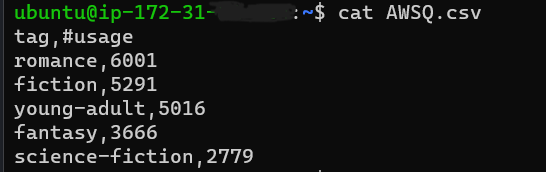


Finally we used the command `time python3 AWSQ.py` to get the execution time of the script. The output of the command is shown below.

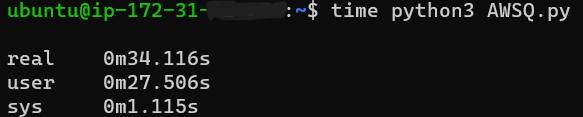


Running the same script on our local machine and using the magic command `%%time` in jupyter notebook to get the execution time, we got the following output.

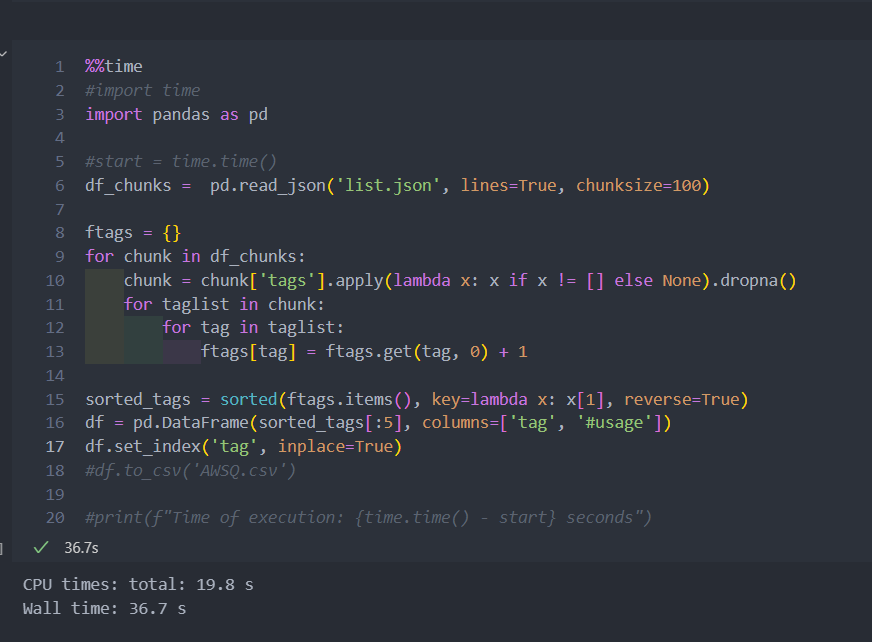


Whereas, by uncommenting all the lines in the code, except to the `df.to_csv()` command and running the script from the terminal we get:


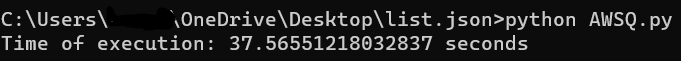

The dataframe we obtain from running the code is the following. We can see it correpsonds with the one we get running the code in the EC2 instance.

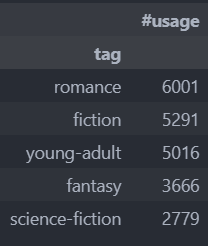


Finally, by running the python code using the magic command `%%timeit` in a jupyter notebook, we get:

-  *26.4 s ± 5.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)*

This is probably better than simply using the `time.start()`, `time.end()` functions since the code is run multiple times and the output is an average of the running times.




---

# Algorithmic Question (AQ)



### 1. Implement a code to answer the problem above

In [ ]:
from collections import deque
d = deque()
i=0
n=int(input())
for _ in range(n):
        command = input().split()
        if command[0]=='R':
            d.append(command[1])
        elif command[0]=='L':
            d.appendleft(command[1])
        elif command[0]=='?':
            while d[i]!=command[1]:
                i+=1
            print(min(i,len(d)-i-1))

### 2. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.

**The answer from ChatGPT:**

To analyze the time complexity of this code, let's break it down step by step:

Initializing d = deque() takes constant time, O(1).

Initializing i = 0 takes constant time, O(1).

Parsing the integer n from the user input using int(input()) also takes constant time, O(1).

The for loop runs n times, and for each iteration, we perform the following operations:

a. Parsing the input string and splitting it using input().split() takes O(M) time, where M is the length of the input string.

b. The if-elif-elif block performs one of three operations based on the value of command[0], and these operations have O(1) time complexity.

c. In the case of the 'R' and 'L' commands, we perform deque operations (d.append() or d.appendleft()), which are generally considered to be O(1) operations.

d. In the case of the '?' command, there is a while loop that iterates through the deque elements. In the worst case, it might iterate through all n elements if the target element is not found. The while loop has a time complexity of O(n) in the worst case.

e. Printing min(i, len(d) - i - 1) takes constant time, O(1).

In the worst case, when all '?' commands require iterating through the entire deque, the time complexity of this code becomes O(n^2). This is because for each of the n '?' commands, we might potentially iterate through the entire deque of up to n elements.

However, in practice, the actual time complexity might be lower if not all '?' commands require iterating through the entire deque. If you can make any assumptions about the input and the frequency of '?' commands, you might be able to optimize the code further.

**Do you believe this is correct? How can you double-check it?**

The answer has few minor mistakes in the explanation but they are not relevant enough to invalidate the reasoning and the final answer, which are correct.

The mistakes:

a.the input has constant length of 2 (ChatGPT didn't have access to the problem introduction)

d.in the worst case, it might iterate through all n-1 elements if the target element is the furthest to the right. (This mistakes were made because ChatGPT didn't know that it is impossible to have a ? command without having the book inserted in the shelf before). The while loop has still a time complexity of O(n) So, even if some assumptions are incorrect, the time complexity of this code becomes O(n^2).

In order to double-check we can analyze the worst-case scenario and show that the number of steps is always lower of cn^2 for some real c, which is exactly what ChatGPT did

### 3. Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

If you want to improve the searching efficiency for the '?' command, you can use a dictionary (hash table) to store the elements in the deque along with their positions. Here's an alternative code that achieves this and has better time complexity for searching:

In [ ]:
from collections import deque

d = deque()
element_positions = {}  # A dictionary to store the positions of elements

n = int(input())

for i in range(n):
    command, value = input().split()

    if command == 'R':
        d.append(value)
        element_positions[value] = len(d) - 1
    elif command == 'L':
        d.appendleft(value)
        element_positions[value] = 0
    elif command == '?':
            position = element_positions[value]
            print(min(position, len(d) - 1 - position))

In this code:

We use a dictionary called element_positions to keep track of the positions of elements in the deque. When adding elements to the deque, we update their positions in the dictionary.

When the '?' command is issued, we can directly access its position in O(1) time. In this case, the complexity of the whole code drops to O(n)

This code provides a more efficient way to search for elements and should work well for scenarios where you need to frequently search for elements in the deque.